In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from utils.utils import Fill_NC_With_Station_Values, aggregate_per_timestep_xr, calculate_metrics
from era5.era5_cropper import Era5ForStationCropper
from train_station_twin.prepare_training_executor_era5 import TrainingPreparation
import torch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from utils.station_utils import apply_aggregation, statistics, calculate_uv, plot_variable_over_time, plot_hist, plot_event_comparison 



In [2]:
def improved_plot_datasets(ds1: xr.DataArray, ds2: xr.DataArray, title1="Ground Truth", title2="Predicted"):
    """
    Improved plot for two xarray DataArrays over time, with enhancements.

    Parameters:
    ds1 (xr.DataArray): First DataArray to plot.
    ds2 (xr.DataArray): Second DataArray to plot.
    title1 (str): Label for the first dataset.
    title2 (str): Label for the second dataset.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2 = xr.align(ds1, ds2)

    # Create a larger figure
    plt.figure(figsize=(14, 8))

    # Plot each dataset with markers and handle missing values (NaN)
    plt.plot(ds1.time, ds1.where(~ds1.isnull()), label=title1, marker='x', linestyle='-', color='blue')
    plt.plot(ds2.time, ds2.where(~ds2.isnull()), label=title2, marker='x', linestyle='-', color='orange', alpha=0.5)

    # Adding labels, title, and legend
    plt.xlabel('Time')
    #plt.ylim(950, 1050)  # Note: reversed y-axis

    plt.ylabel('Precipitaion in mm')
    plt.title('Comparison of Ground Truth vs Predicted Pressure Vienna')
    plt.legend()

    # Rotate x-axis labels and add grid for better readability
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [3]:
def improved_plot_datasets_3(ds1: xr.DataArray, ds2: xr.DataArray, ds3: xr.DataArray,
                           title1="Ground Truth/Measurement", title2="Predicted", title3="ERA5 Nearest Grid Point",
                           start_date: str = None, end_date: str = None, 
                           df: pd.DataFrame = None, df_label: str = "Station Data"):
    """
    Improved plot for three xarray DataArrays over time, with enhancements and an option to include a pandas DataFrame.

    Parameters:
    ds1 (xr.DataArray): First DataArray to plot (e.g., Ground Truth).
    ds2 (xr.DataArray): Second DataArray to plot (e.g., Predicted).
    ds3 (xr.DataArray): Third DataArray to plot (e.g., ERA5 Nearest Grid Point).
    title1 (str): Label for the first dataset.
    title2 (str): Label for the second dataset.
    title3 (str): Label for the third dataset.
    start_date (str, optional): Start date for filtering (e.g., "2024-03-01").
    end_date (str, optional): End date for filtering (e.g., "2024-03-31").
    df (pd.DataFrame, optional): A pandas DataFrame with a datetime column/index and values to plot.
    df_label (str): Label for the pandas DataFrame in the legend.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2, ds3 = xr.align(ds1, ds2, ds3)

    # Filter xarray datasets by the specified time range if provided
    if start_date or end_date:
        time_slice = slice(start_date, end_date)
        ds1 = ds1.sel(time=time_slice)
        ds2 = ds2.sel(time=time_slice)
        ds3 = ds3.sel(time=time_slice)

    # Filter pandas DataFrame by the specified time range if provided
    if df is not None:
        if start_date:
            df = df[df.index >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df.index <= pd.to_datetime(end_date)]

    # Create a larger figure
    plt.figure(figsize=(16, 10))

    # Plot each xarray dataset with markers and handle missing values (NaN)
    plt.plot(ds1.time, ds1, label=title1, marker='x', linestyle='-', color='blue', alpha=0.9)
    plt.plot(ds2.time, ds2, label=title2, marker='x', linestyle='-', color='orange', alpha=0.9)
    plt.plot(ds3.time, ds3, label=title3, marker='x', linestyle='-', color='green', alpha=0.9)

    # Plot pandas DataFrame if provided
    if df is not None:
        plt.plot(df.index, df.values, label=df_label, marker='o', linestyle='--', color='red', alpha=0.1)

    # Adding labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('Precipitation in mm')
    plt.title('Comparison of Ground Truth, Predicted, ERA5, and Station Data')
    plt.legend()

    # Rotate x-axis labels and add grid for better readability
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [4]:
def plot_era5_precipitation(
    dataset_path,
    variable='tp',
    point_coords=(-59.54316, 13.16443),
    time_range=("2021-01-07 00:00", "2021-01-07 23:00"),
    title_base='Total Precipitation Barbados Event 1',
    cmap='viridis',
):
    """
    Plots ERA5 precipitation data for a specific time range and location.
    
    Parameters:
    - dataset_path (str): Path to the ERA5 dataset (netCDF file).
    - variable (str): Name of the variable to plot (default: 'tp').
    - point_coords (tuple): Longitude and latitude of the specific point (default: (-59.54316, 13.16443)).
    - time_range (tuple): Start and end times for the data to plot (default: ("2021-01-07 00:00", "2021-01-07 23:00")).
    - title_base (str): Base title for the plots (default: 'Total Precipitation Barbados Event 1').
    - cmap (str): Colormap for the plots (default: 'viridis').
    """
    # Open the dataset
    era5_data = xr.open_dataset(dataset_path)

    # Extract coordinates and data
    lat = era5_data.lat.values
    lon = era5_data.lon.values
    point_lon, point_lat = point_coords

    # Select the time range
    selected_data = era5_data.sel(time=slice(*time_range))

    # Create a meshgrid for pcolormesh
    Lon, Lat = np.meshgrid(lon, lat)

    # Define plot parameters
    vmin = selected_data[variable].min().item()
    vmax = selected_data[variable].max().item()

    for t in selected_data.time:
        # Create a new figure with Cartopy's PlateCarree projection
        fig, ax = plt.subplots(
            figsize=(10, 8),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )

        # Extract data for the current time step
        data = selected_data[variable].sel(time=t).values

        # Handle missing or invalid data
        data = np.ma.masked_invalid(data)

        # Plot the data using pcolormesh
        pcm = ax.pcolormesh(
            Lon, Lat, data, 
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            transform=ccrs.PlateCarree()
        )

        # Add coastlines and borders
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)

        # Plot the specific point
        ax.plot(
            point_lon, point_lat,
            marker='x', color='red', markersize=12,
            transform=ccrs.PlateCarree(),
            label='Specific Point'
        )

        # Add a colorbar
        cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
        cbar.set_label('Precipitation (mm)', fontsize=12)

        # Set title with time information
        time_str = pd.to_datetime(t.values).strftime('%Y-%m-%d %H:%M')
        plt.title(f'{title_base} at {time_str}', fontsize=16, pad=20)

        # Add legend for the point marker
        ax.legend(loc='lower left', fontsize=12)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()

        # Close the figure to free memory
        plt.close(fig)



In [5]:
# Load ERA5 Data
# this covers the period 2020-2023 and is in 9x9 grid
era5_barbados = xr.open_dataset('era5_data/era5_barbados_allvar/barbados_all_var_2020_2024_renamed.nc') 
era5_barbados

# era5_data/er5_newhook/vienna_allvar_2017-2024_renamed.nc

<xarray.Dataset>
Dimensions:  (time: 42783, lon: 17, lat: 17)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2024-11-17T14:00:00
  * lon      (lon) float64 298.5 298.7 299.0 299.2 ... 301.7 302.0 302.2 302.5
  * lat      (lat) float64 15.17 14.91 14.66 14.41 ... 11.91 11.66 11.41 11.16
Data variables:
    10u      (time, lat, lon) float32 ...
    10v      (time, lat, lon) float32 ...
    2d       (time, lat, lon) float32 ...
    2t       (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Nov 26 15:37:19 2024: cdo -f nc4 copy era5_data/era5_ba...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [6]:
# load hourly station data
barbados_hourly_df = pd.read_csv("station_data_processed/barbados_hourly_aggregated_data.csv", index_col=0,  parse_dates=True)
barbados_hourly_df.head()
# barbados_hourly_df["tipping"].dropna()
barbados_hourly_df

# station_data_processed/vienna_hourly_aggregated_data.csv

,bmp280_temp,bmp280_pres,bmp280_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_speed
datetime,,,,,,,,,,,
2020-06-08 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-06-08 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-06-08 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-06-08 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-06-08 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 15:00:00,28.66,982.875,1013.750,10.4,NaN,27.30,0.0,845.0,6304.5,315.0,2.128167
2023-11-22 16:00:00,29.05,982.170,1012.980,11.6,NaN,27.60,0.0,923.0,7158.5,356.5,2.052167
2023-11-22 17:00:00,28.84,981.645,1012.470,11.7,NaN,27.40,0.0,730.0,5044.5,253.5,2.274000


In [7]:
# load minutels station data
barbados_df = pd.read_csv("station_data_processed/barbados_hourly_processed_data.csv", index_col=0,  parse_dates=True)
barbados_df.head()
# barbados_hourly_df["tipping"].dropna()
barbados_df


,bmp180_temp,bmp180_pres,bmp180_slp,bmp180_alt,bmp280_temp,bmp280_pres,bmp280_slp,bmp280_alt,bme_temp,bme_pres,...,bme_hum,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
datetime,,,,,,,,,,,,,,,,,,,,,
2020-06-08 15:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.00
2020-06-08 15:38:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.00
2020-06-08 15:39:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.00
2020-06-08 15:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.00
2020-06-08 15:41:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:20:00,NaN,NaN,NaN,NaN,28.32,981.07,1011.92,274.0,NaN,NaN,...,NaN,11.9,NaN,26.8,0.0,542.0,3137.0,153.0,0.0,1.47
2023-11-22 19:21:00,NaN,NaN,NaN,NaN,28.30,981.05,1011.91,274.0,NaN,NaN,...,NaN,11.4,NaN,26.8,0.0,532.0,3034.0,147.0,0.0,NaN
2023-11-22 19:22:00,NaN,NaN,NaN,NaN,28.29,981.05,1011.91,274.0,NaN,NaN,...,NaN,11.6,NaN,26.9,NaN,487.0,2506.0,123.0,NaN,NaN


In [7]:
output_output = xr.open_dataset("executed_trainings/Barbados_tp_withzero_20241128-16/model/output_output.nc")
output_gt = xr.open_dataset("executed_trainings/Barbados_tp_withzero_20241128-16/model/output_gt.nc")

In [8]:
output_output = xr.open_dataset("executed_trainings/Barbados_tp_nonzero_20241129-11/model/output_output.nc")
output_gt = xr.open_dataset("executed_trainings/Barbados_tp_nonzero_20241129-11/model/output_gt.nc")

In [9]:
output_output.tp.values

array([[[0.7320255 , 0.73342097, 0.72946763, ..., 0.7192248 ,
         0.72408426, 0.72810113],
        [0.73075366, 0.7330048 , 0.7281239 , ..., 0.71518135,
         0.7212168 , 0.72978806],
        [0.7354938 , 0.7378049 , 0.7323954 , ..., 0.71754634,
         0.7245896 , 0.7344943 ],
        ...,
        [0.72497594, 0.72532165, 0.7163129 , ..., 0.70882356,
         0.7134522 , 0.7221019 ],
        [0.7489295 , 0.74416614, 0.7310449 , ..., 0.7221806 ,
         0.7243595 , 0.7308508 ],
        [0.7633811 , 0.75211525, 0.73643136, ..., 0.72484875,
         0.72412574, 0.73532295]],

       [[0.74133587, 0.7463151 , 0.7452868 , ..., 0.7460587 ,
         0.7517741 , 0.7564248 ],
        [0.7417176 , 0.7470201 , 0.7447597 , ..., 0.74238634,
         0.7495986 , 0.75948894],
        [0.7480861 , 0.7531254 , 0.75004196, ..., 0.74526393,
         0.7538028 , 0.7653903 ],
        ...,
        [0.7444123 , 0.7476193 , 0.7407844 , ..., 0.7402253 ,
         0.7457026 , 0.7553538 ],
        [0.7

In [117]:

# Example usage
aggregated_output_output = aggregate_per_timestep_xr(output_output, methods=["mean", "std", "var", "max"], variables=["tp"])
aggregated_output_gt = aggregate_per_timestep_xr(output_gt,  methods=["mean", "std", "var", "max"], variables=["tp"])
#aggregated_input_gt = aggregate_per_timestep_xr(input_gt,  methods=["mean", "std", "var", "max"], variables=["10v"])

aggregated_output_output.mean_tp.mean()

<xarray.DataArray 'mean_tp' ()>
array(0.8674584, dtype=float32)

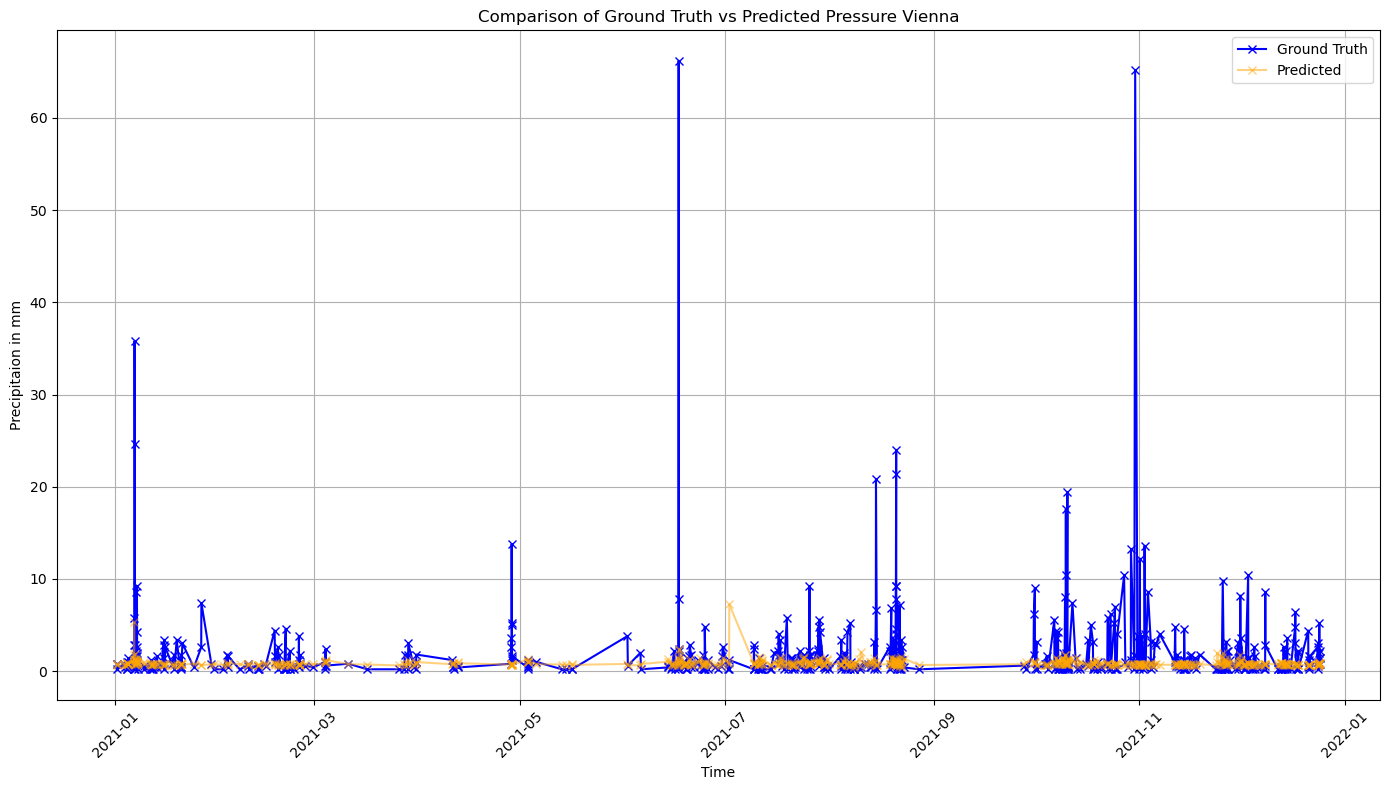

In [120]:

# Usage
improved_plot_datasets(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp )


In [121]:
# Load the ERA5 dataset

# Define the target latitude and longitude
station_lat = 13.16443 #48.2303
station_lon =  -59.54316  #16.3609   # Example: Vienna longitude

# Select the nearest grid point
nearest_grid_point = era5_barbados.sel(lat=station_lat, lon=station_lon, method="nearest")


# Access a specific variable if needed
variable_nearest_grid = nearest_grid_point["tp"] 
variable_nearest_grid

<xarray.DataArray 'tp' (time: 42783)>
[42783 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2024-11-17T14:00:00
    lon      float64 298.5
    lat      float64 13.16

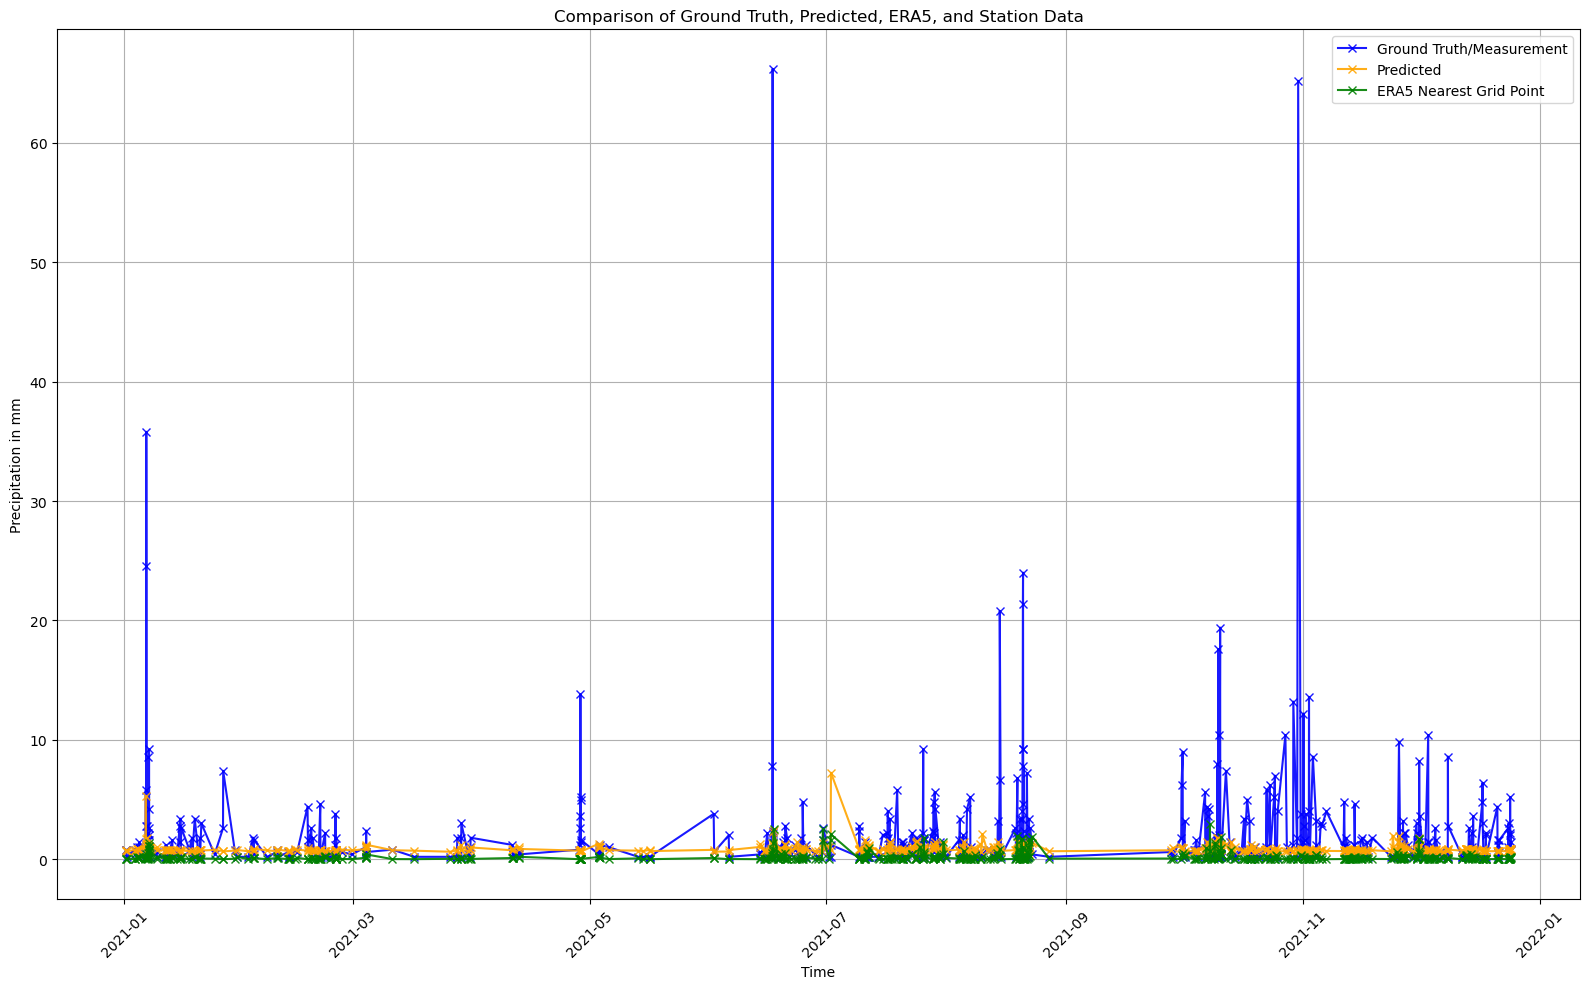

In [124]:
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid,  start_date = "2021-01-01", end_date = "2021-12-31")


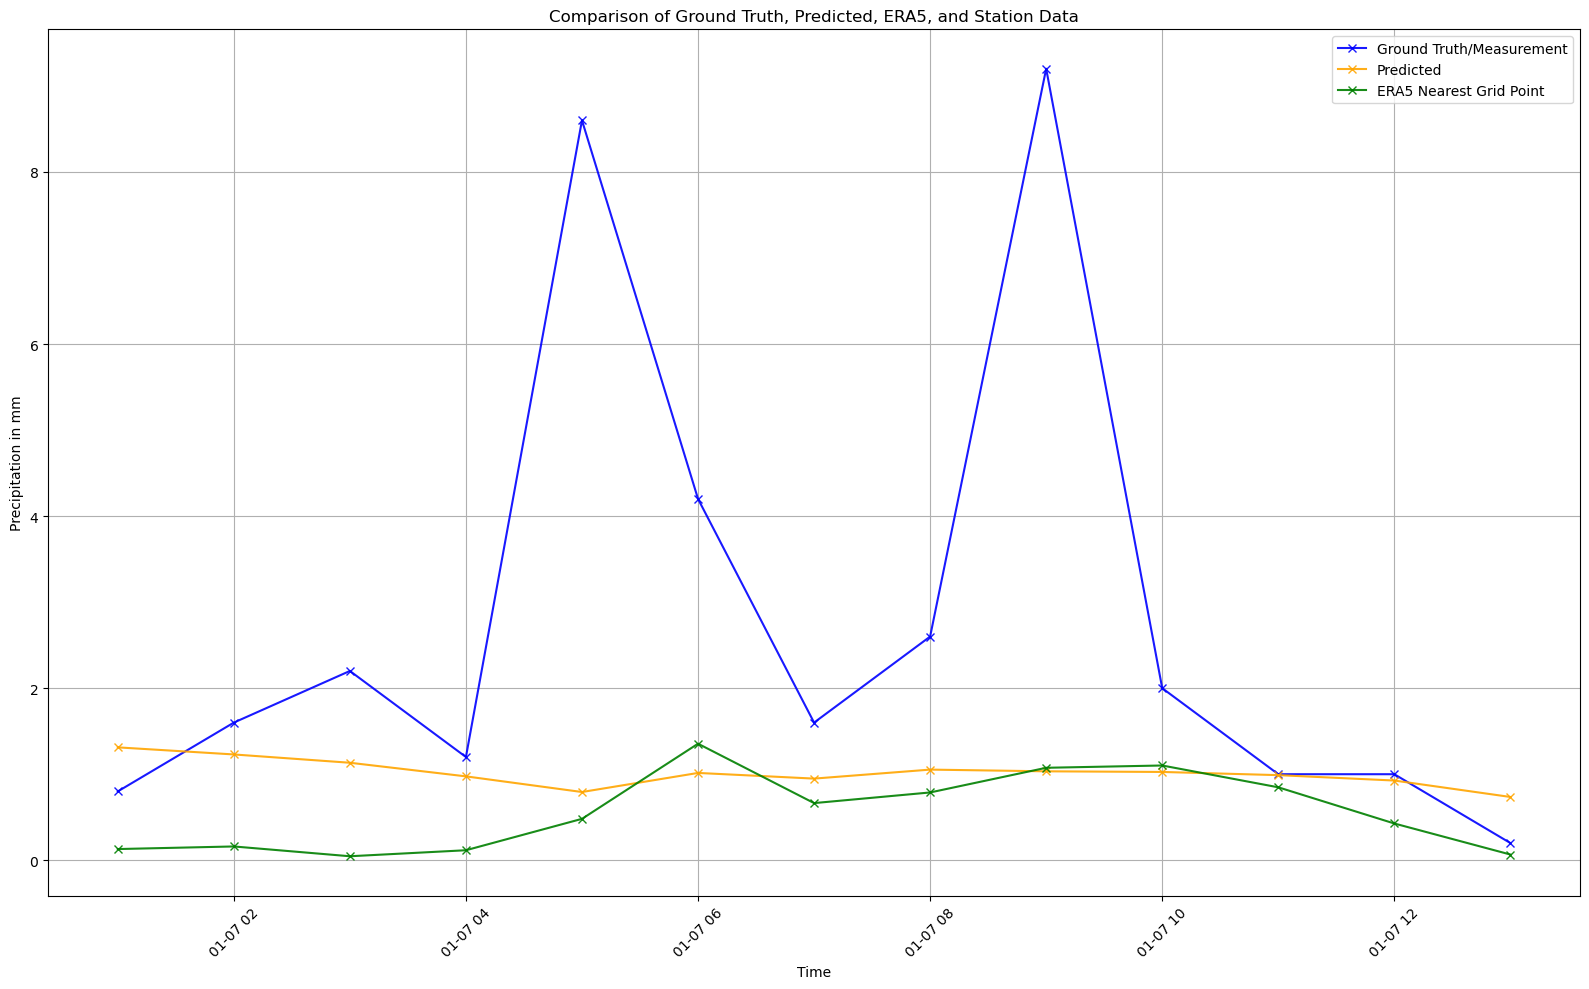

In [125]:

# Usage
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid,  start_date = "2021-01-07", end_date = "2021-01-07")


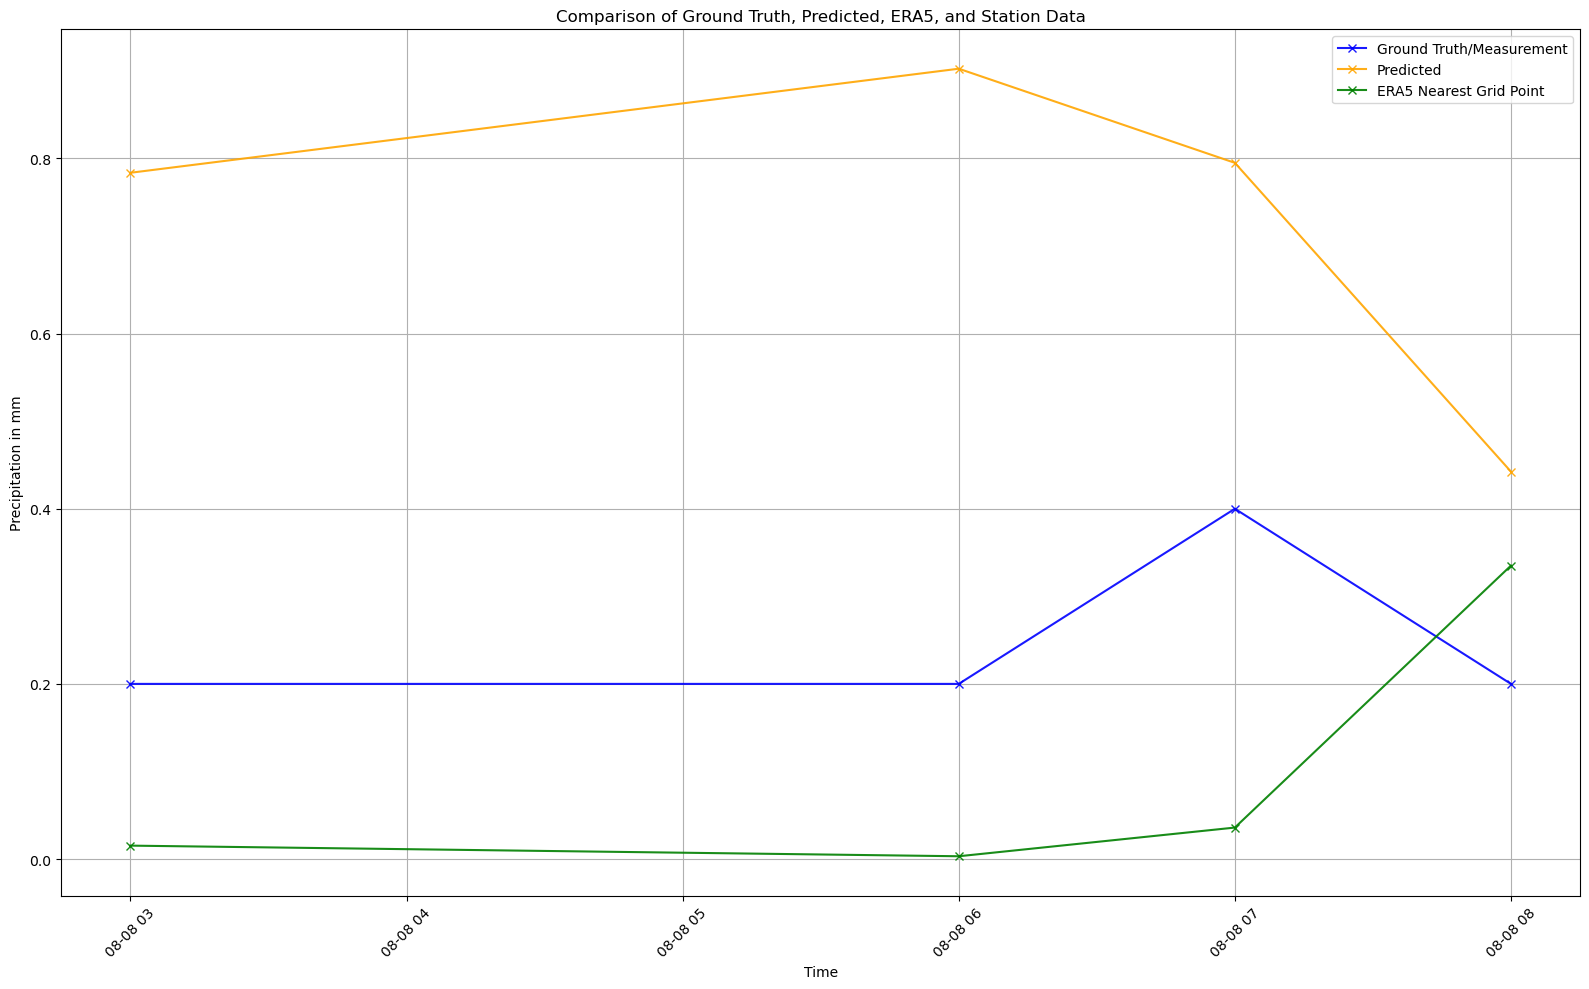

In [126]:
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid, start_date = "2021-08-08", end_date = "2021-08-08")


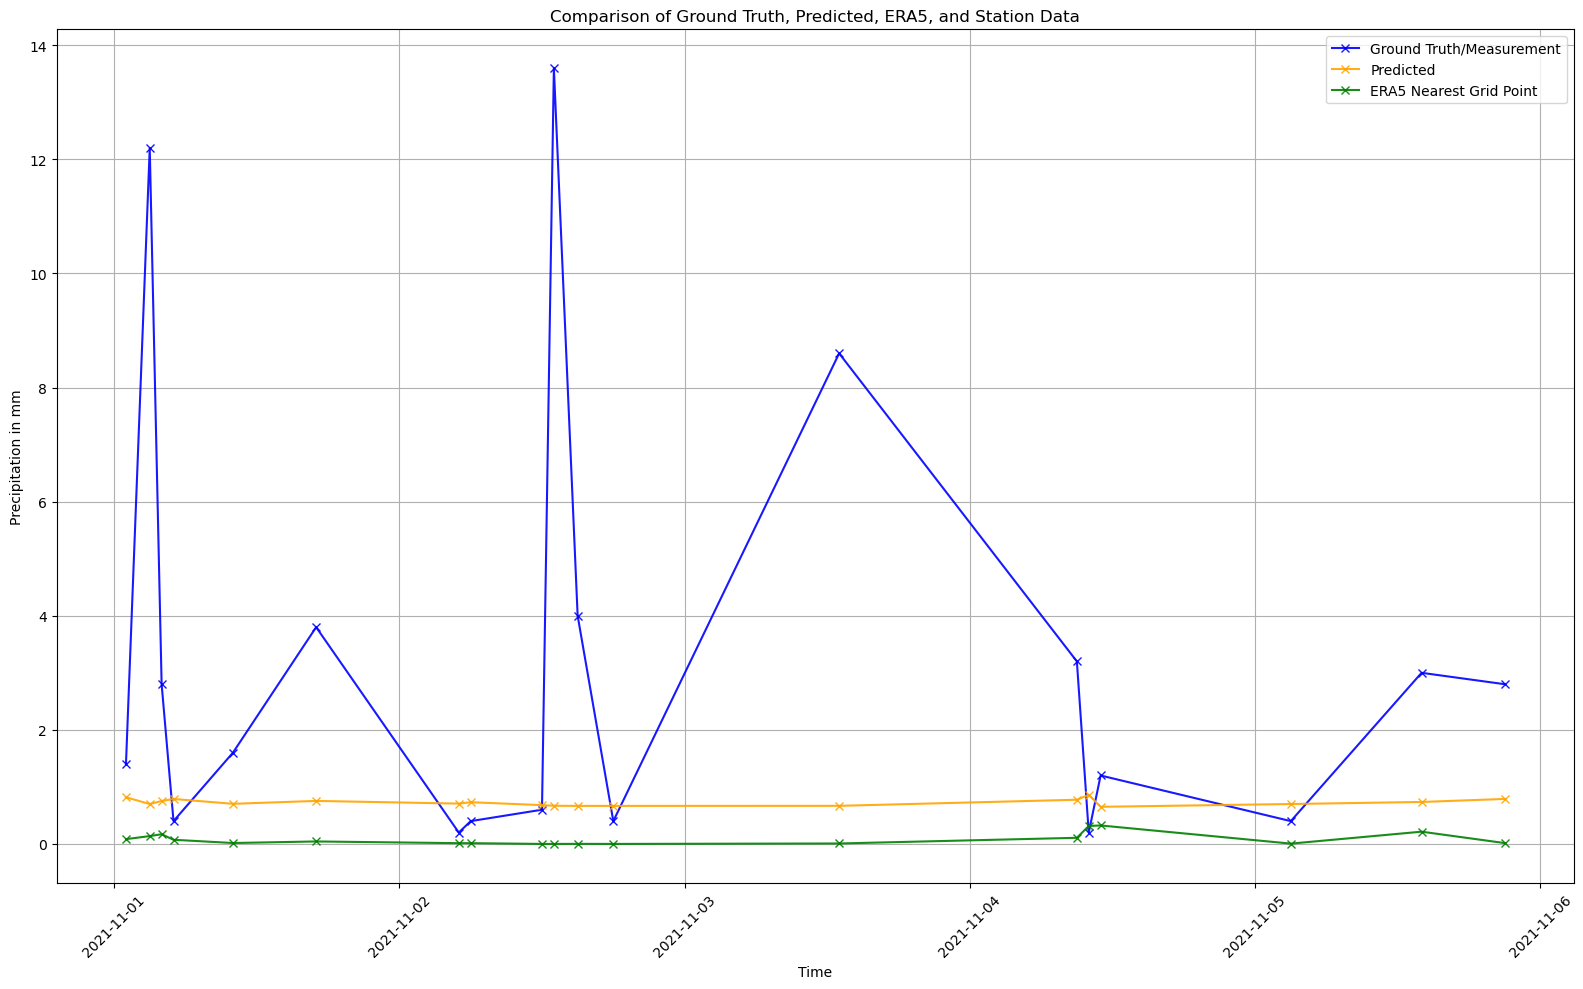

In [127]:
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid, start_date = "2021-11-01", end_date = "2021-11-05")


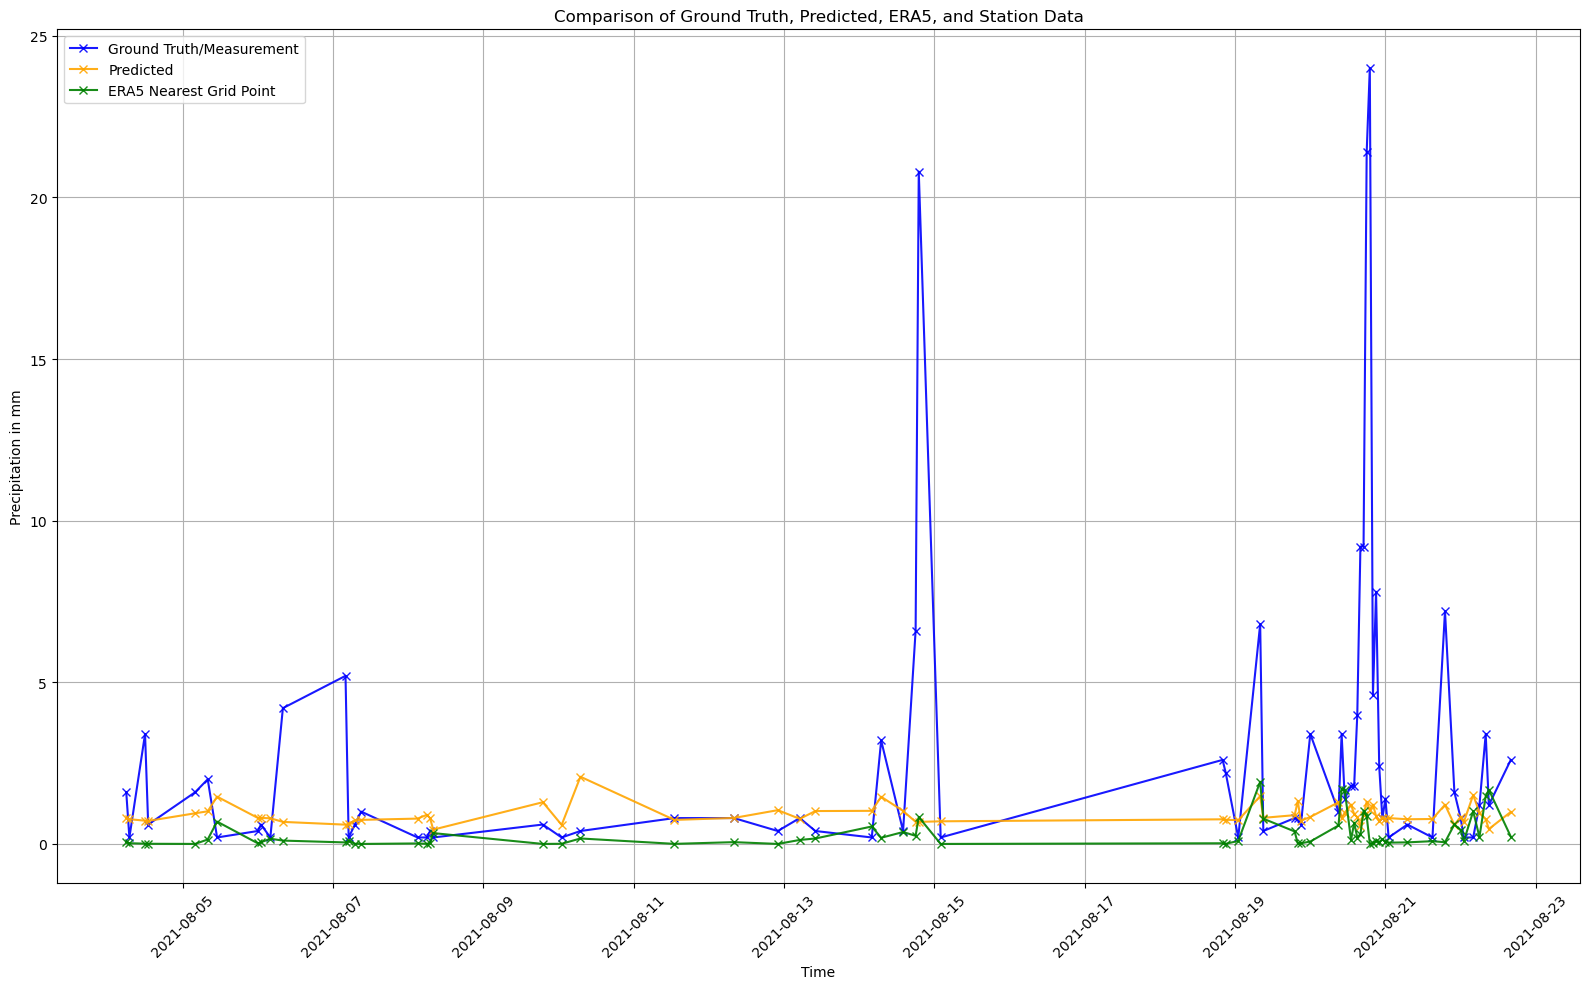

In [128]:
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid,  start_date = "2021-08-01", end_date = "2021-08-22")


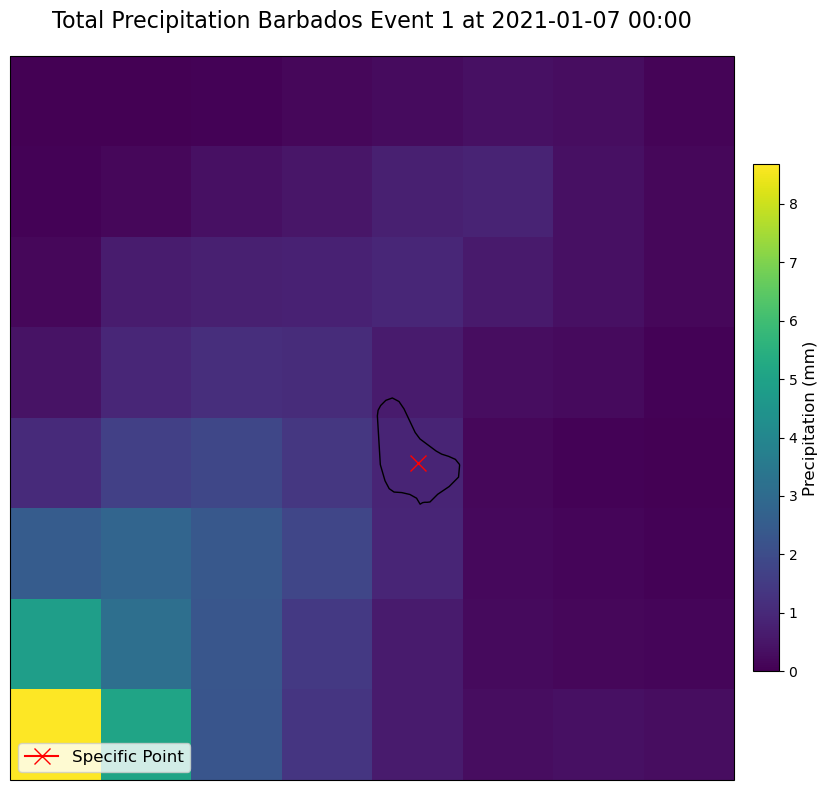

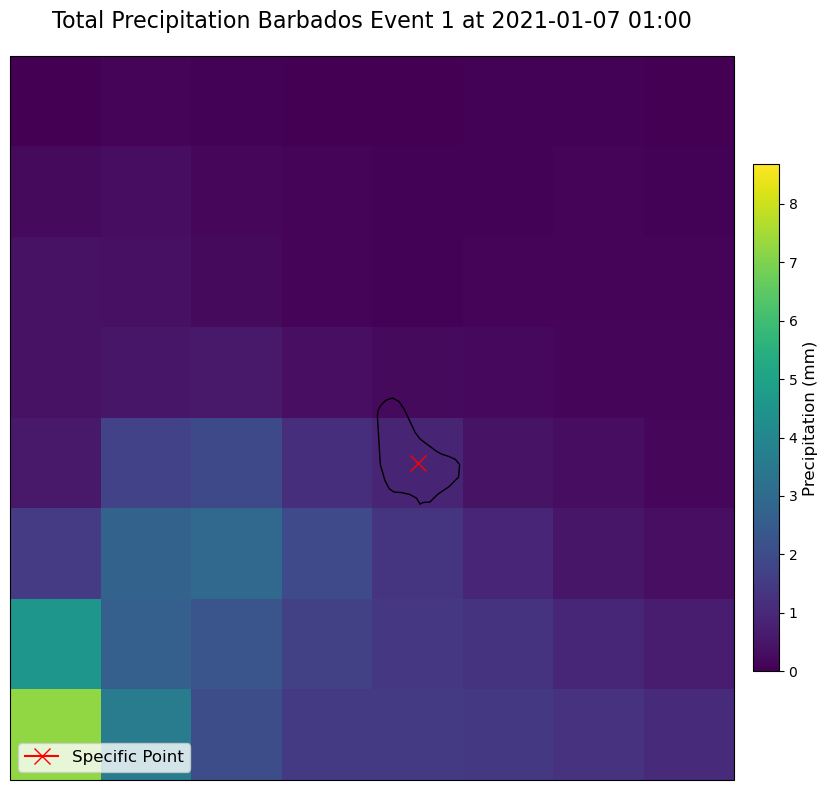

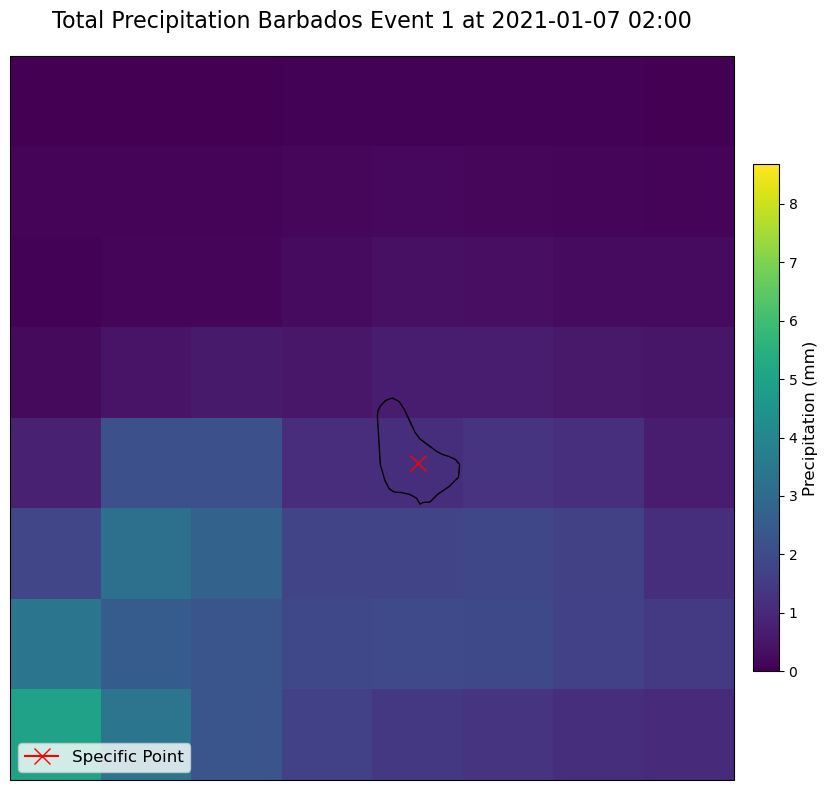

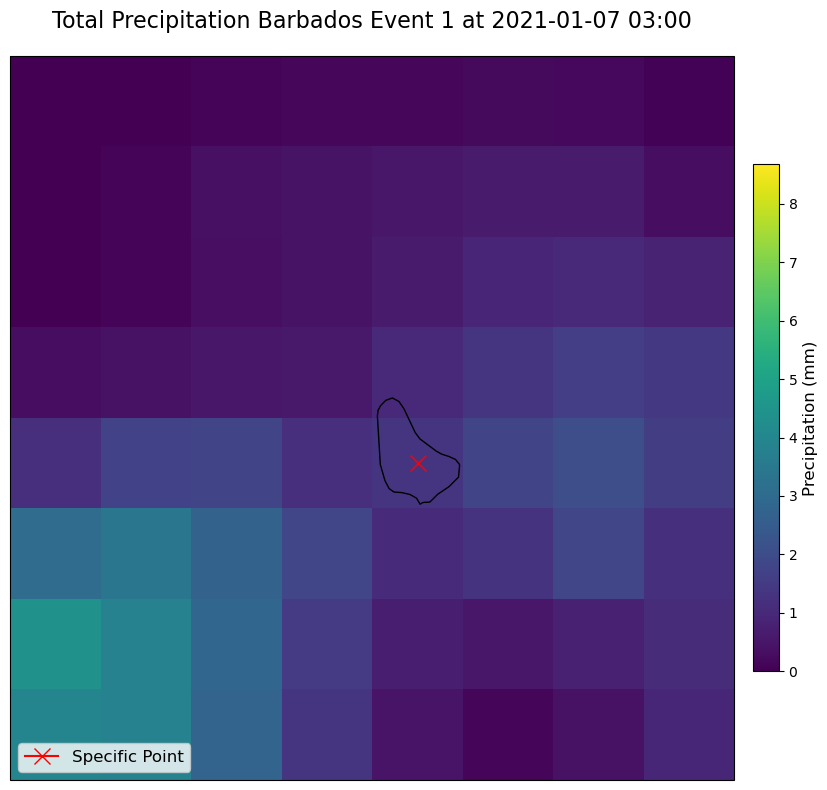

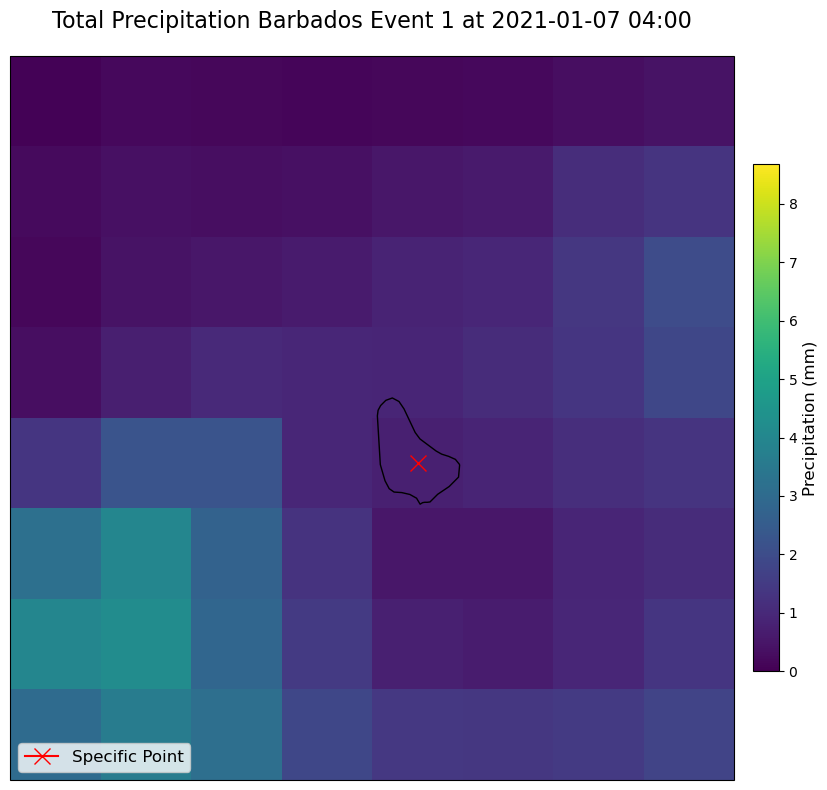

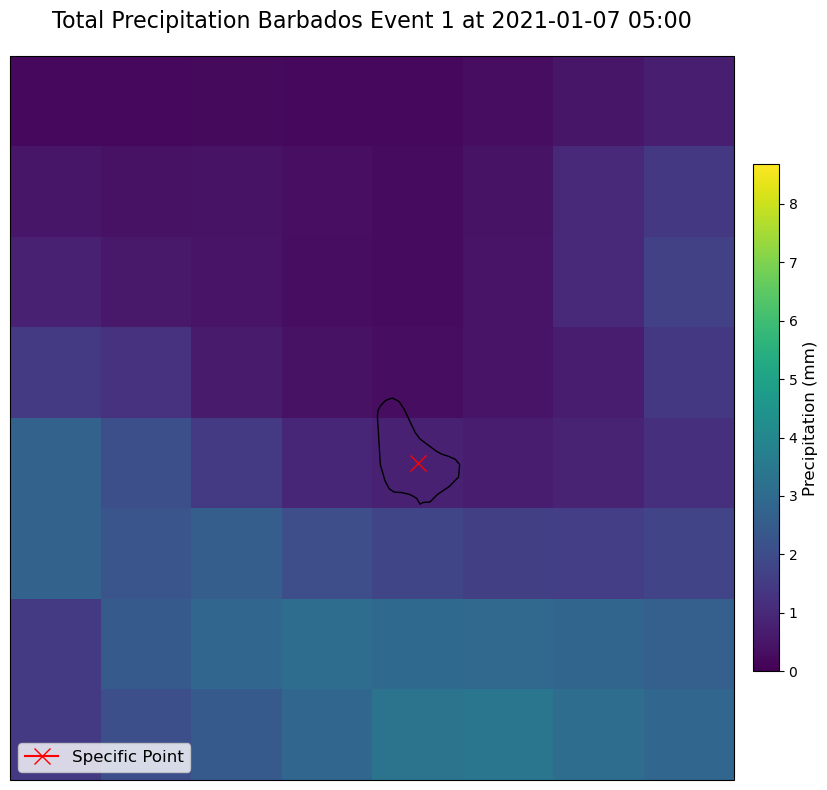

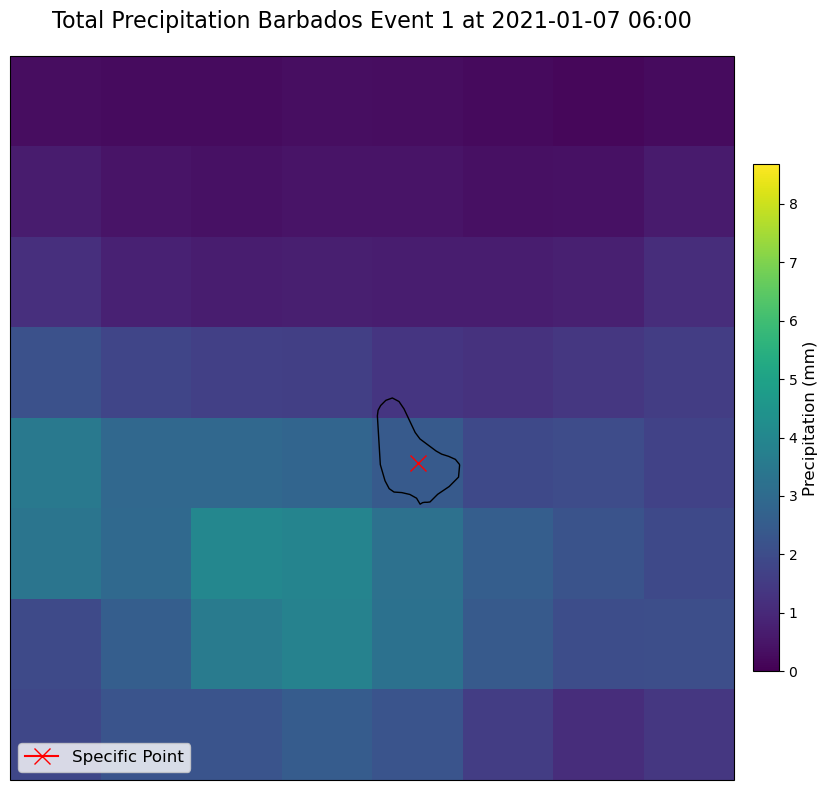

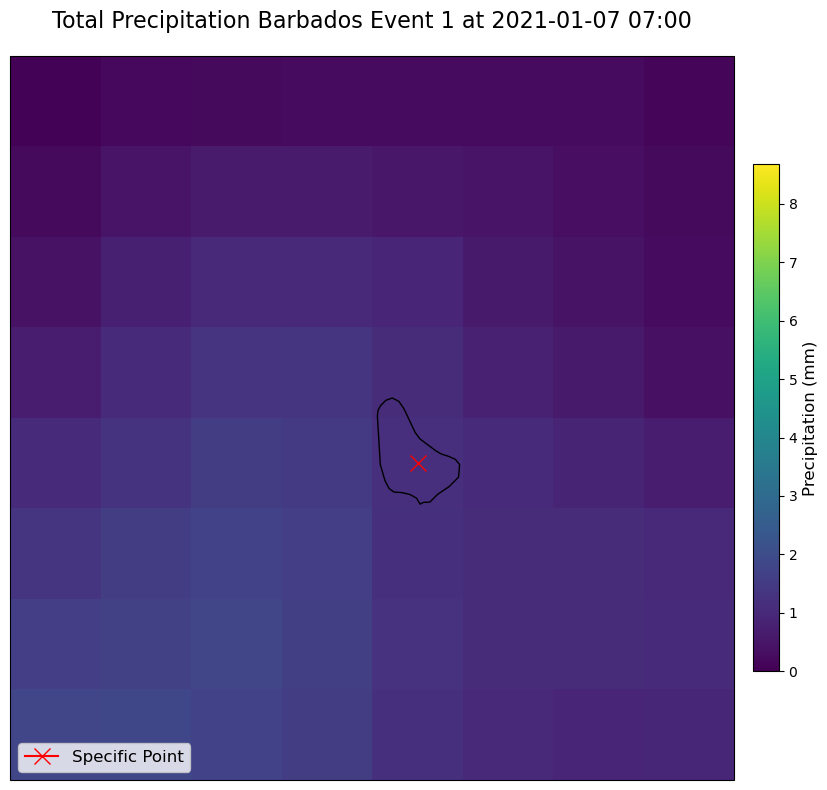

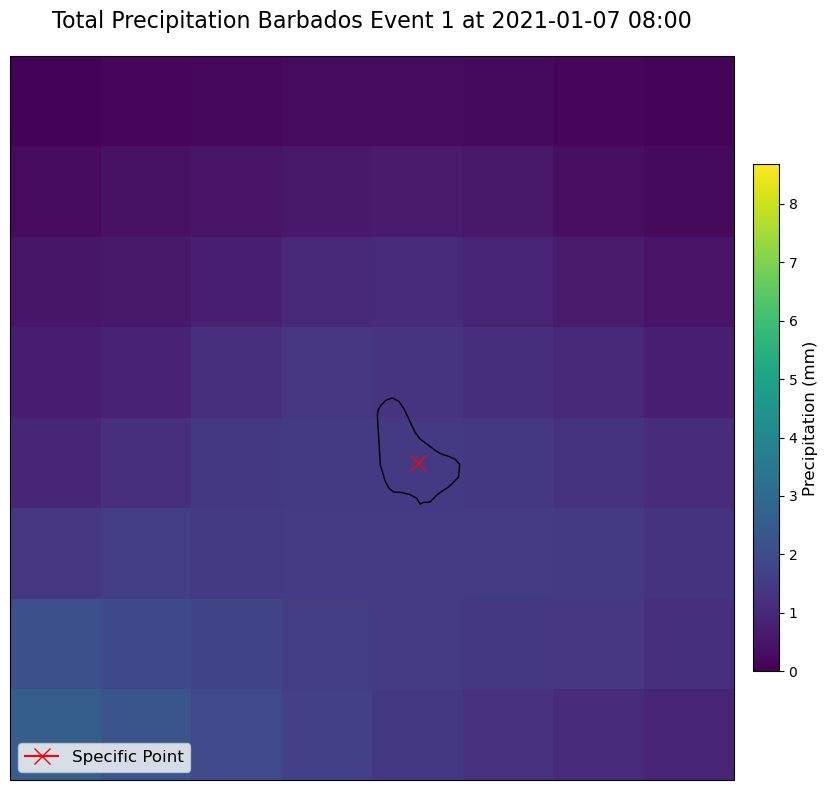

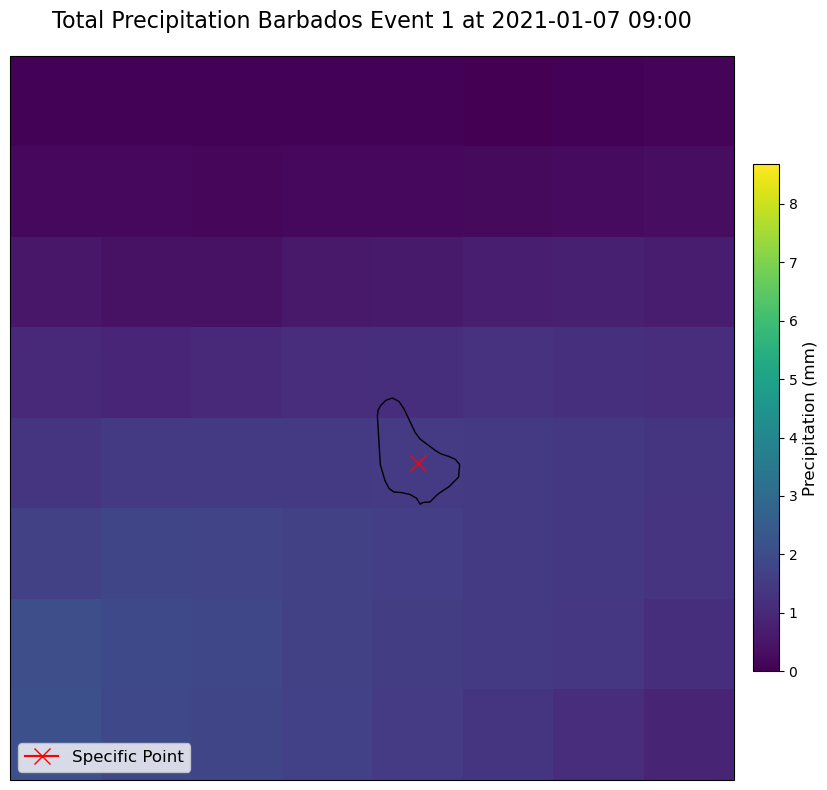

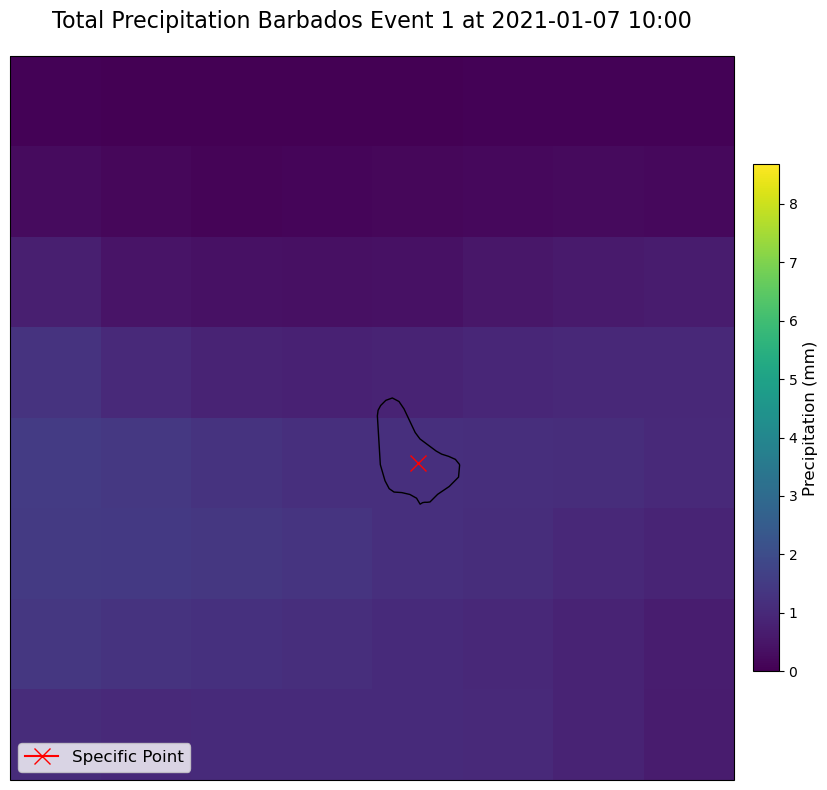

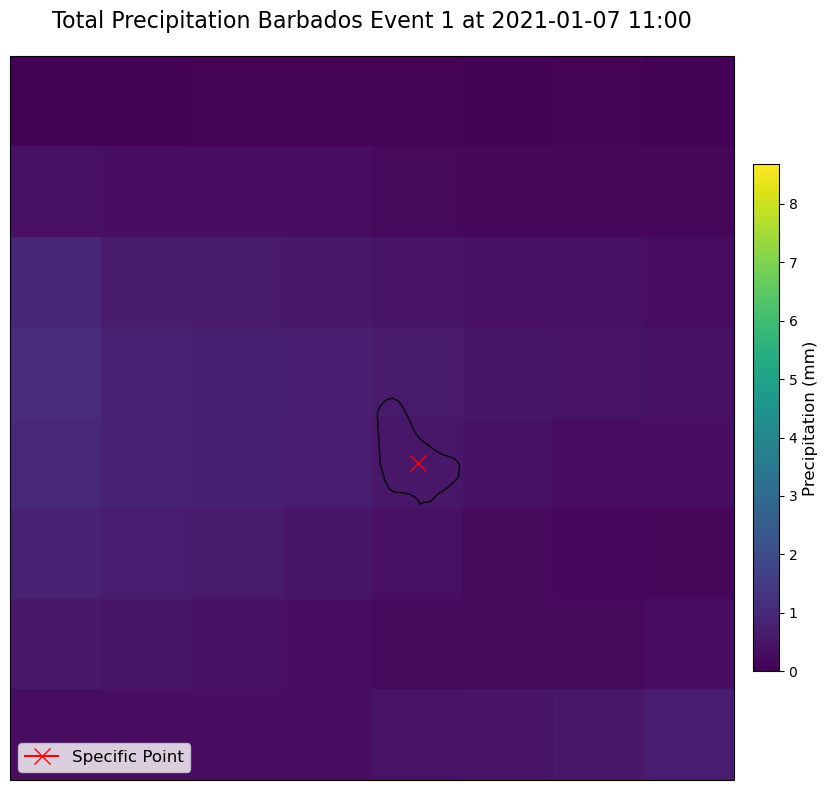

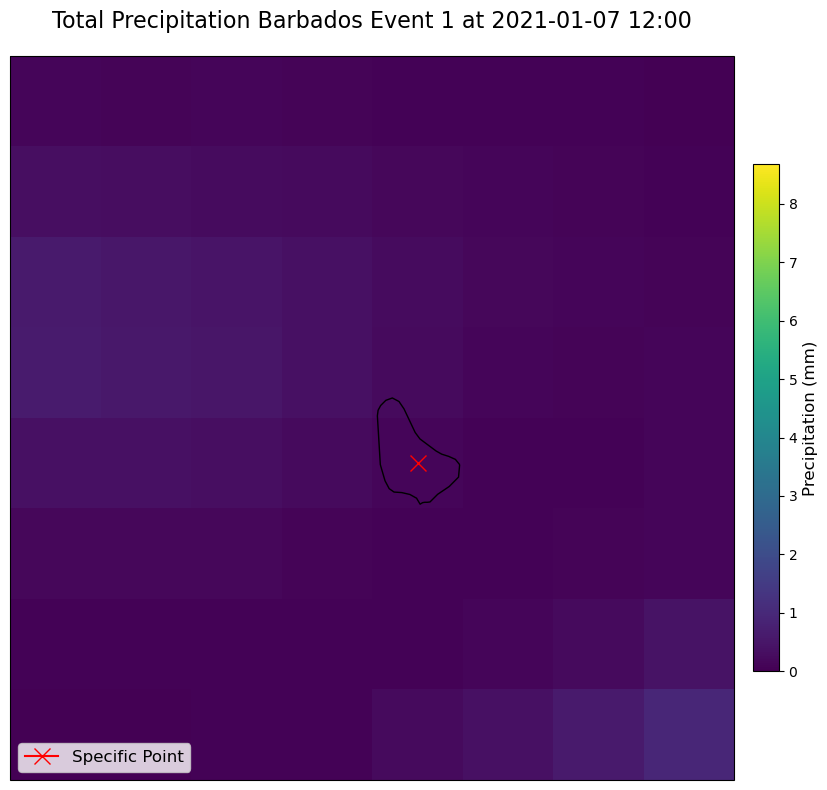

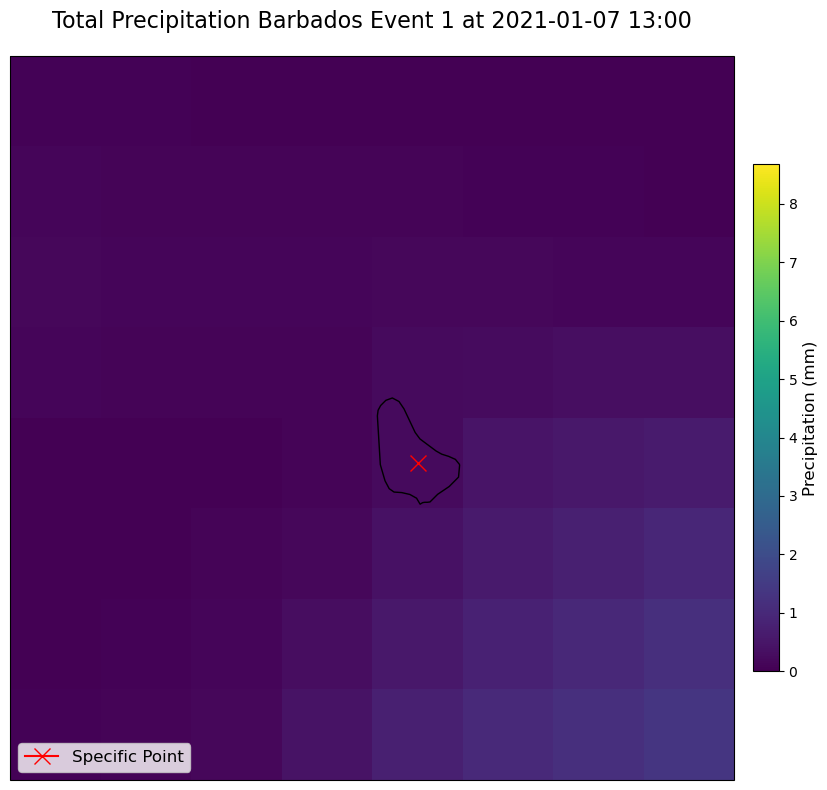

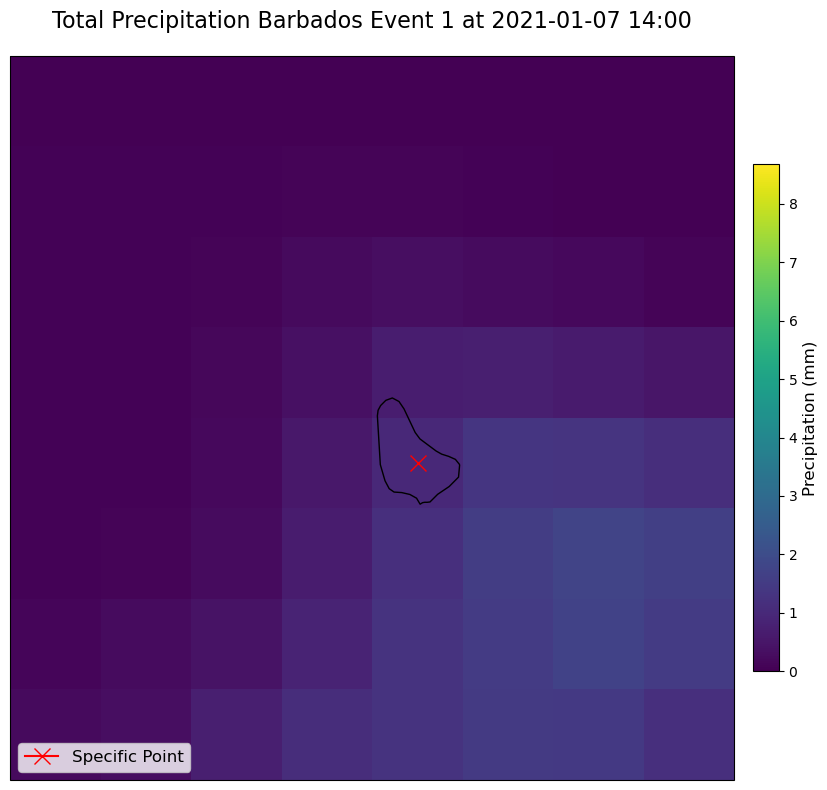

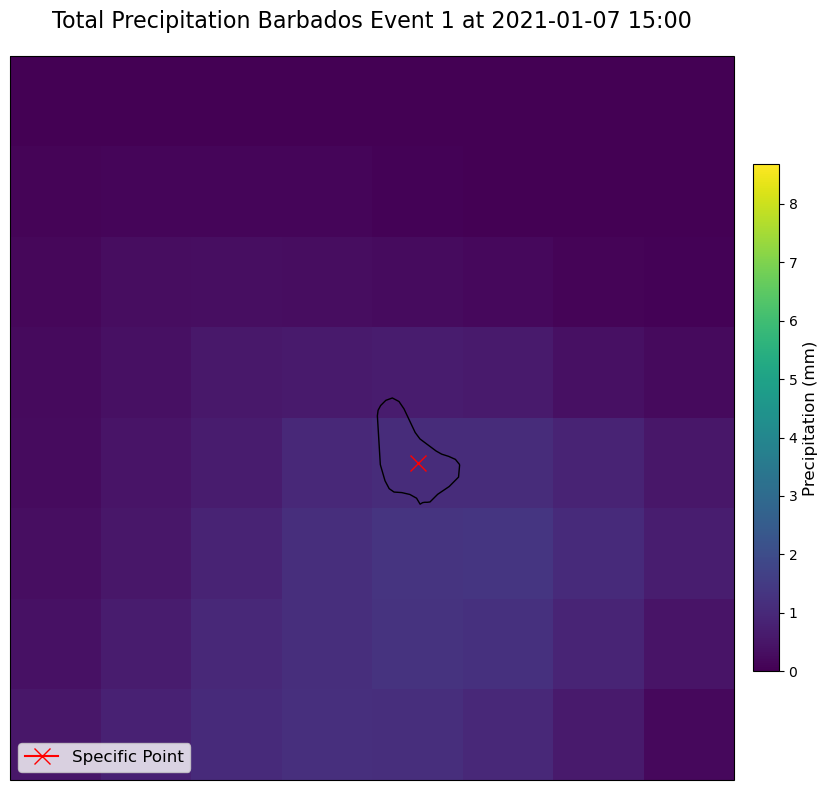

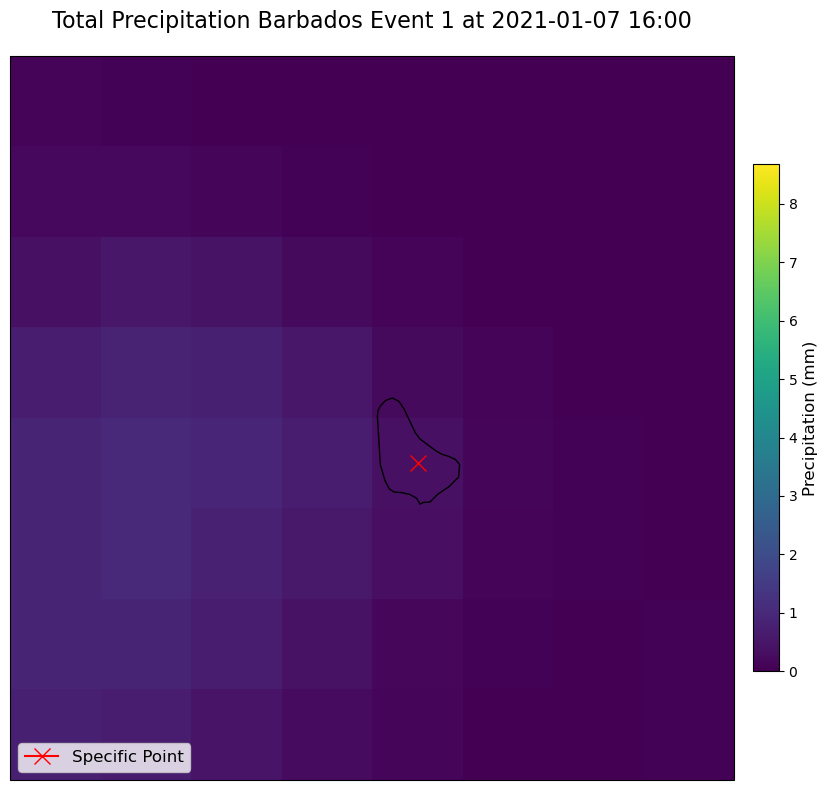

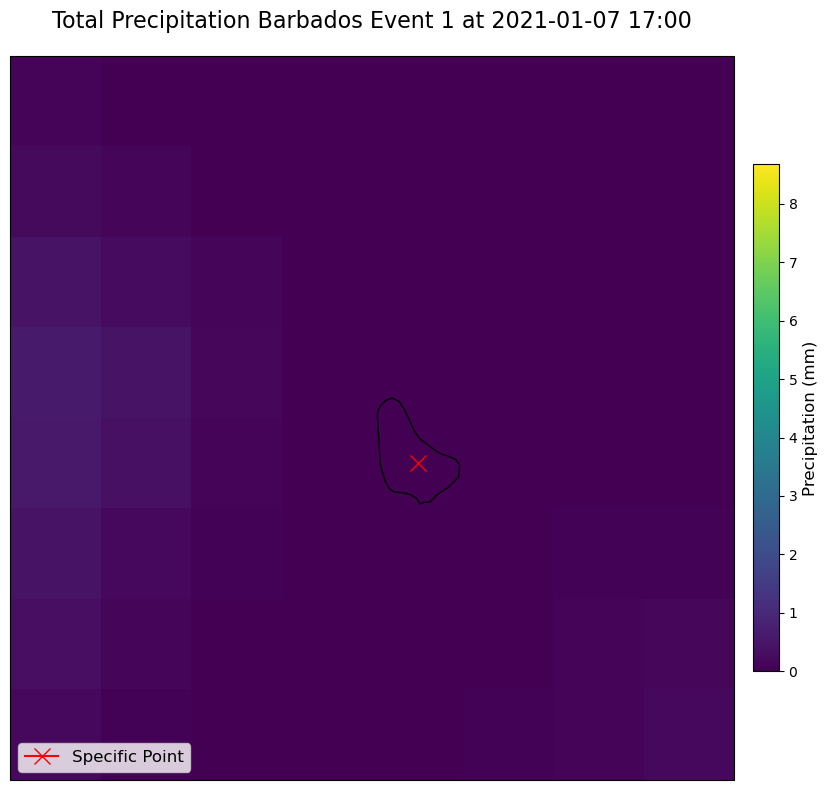

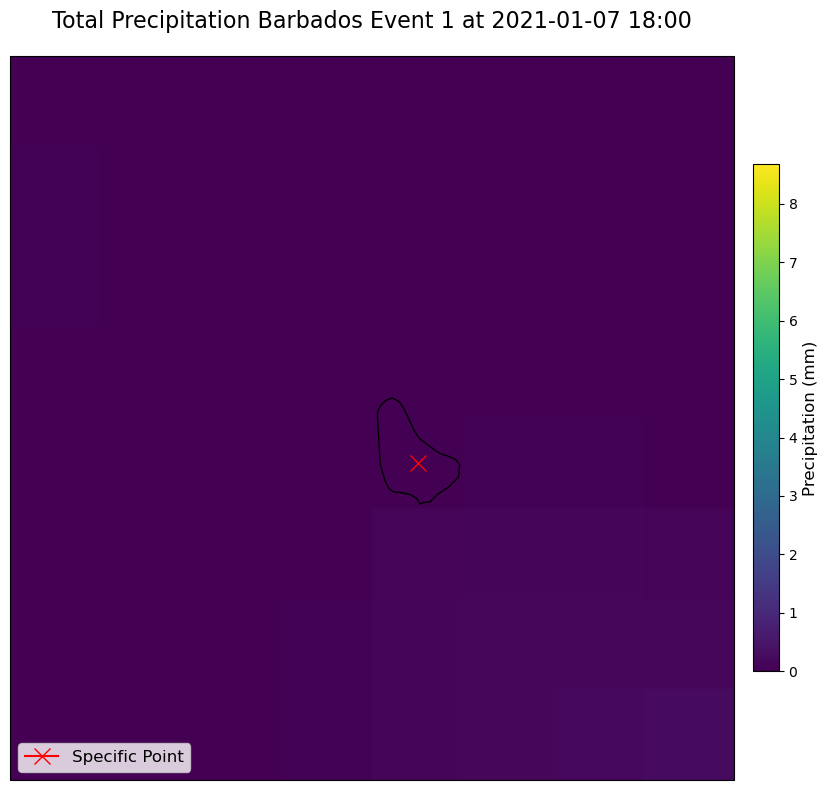

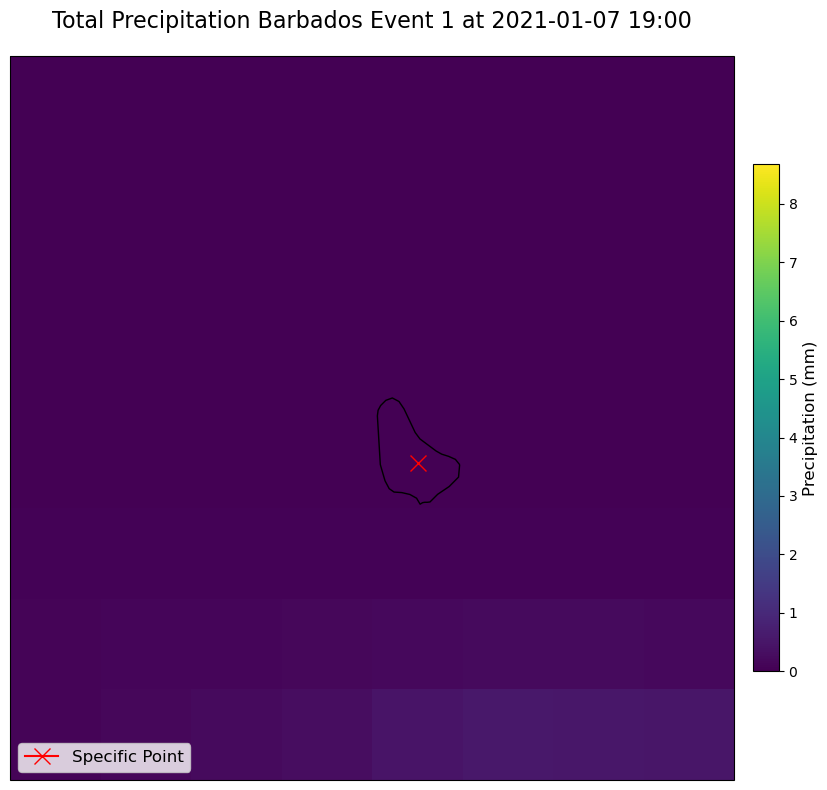

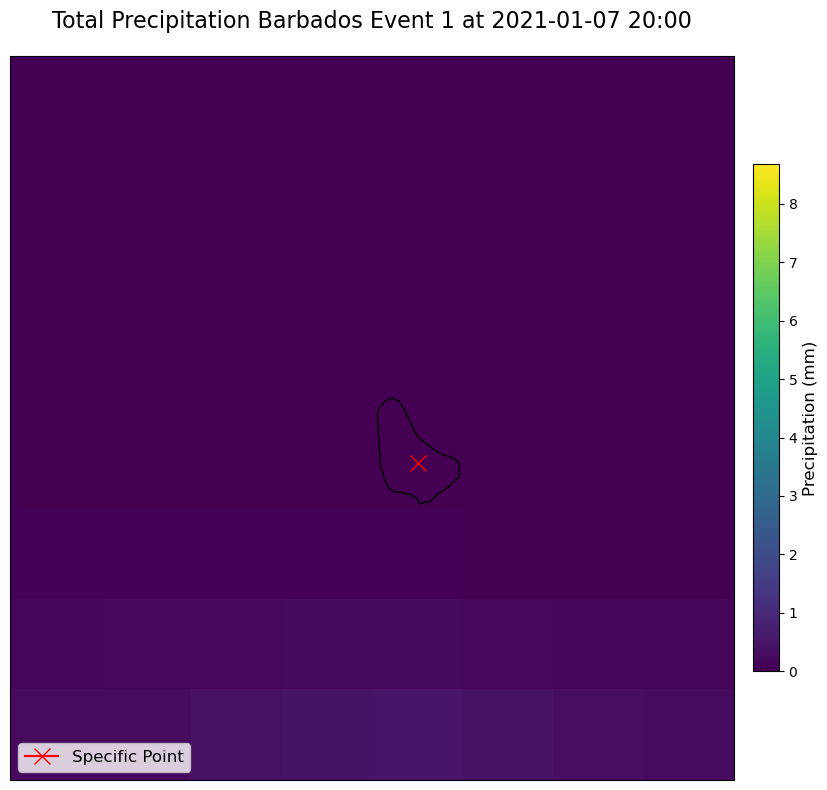

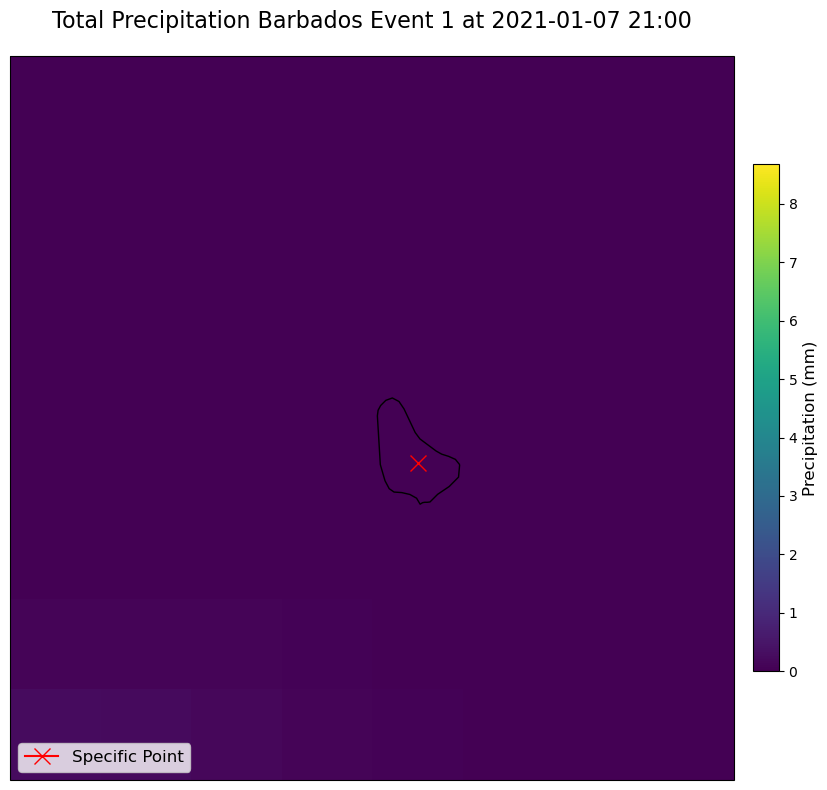

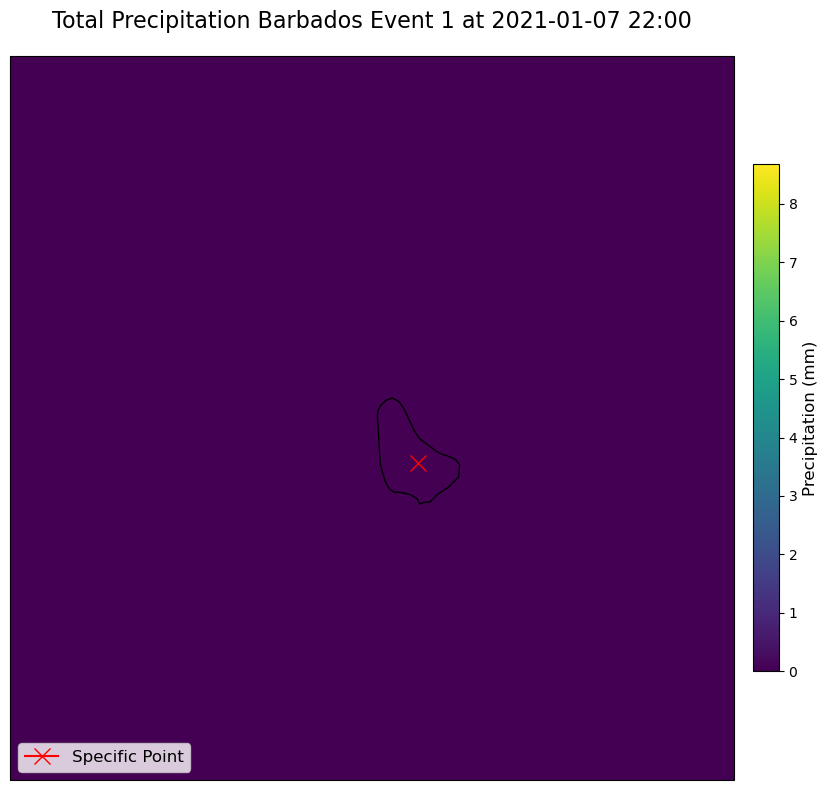

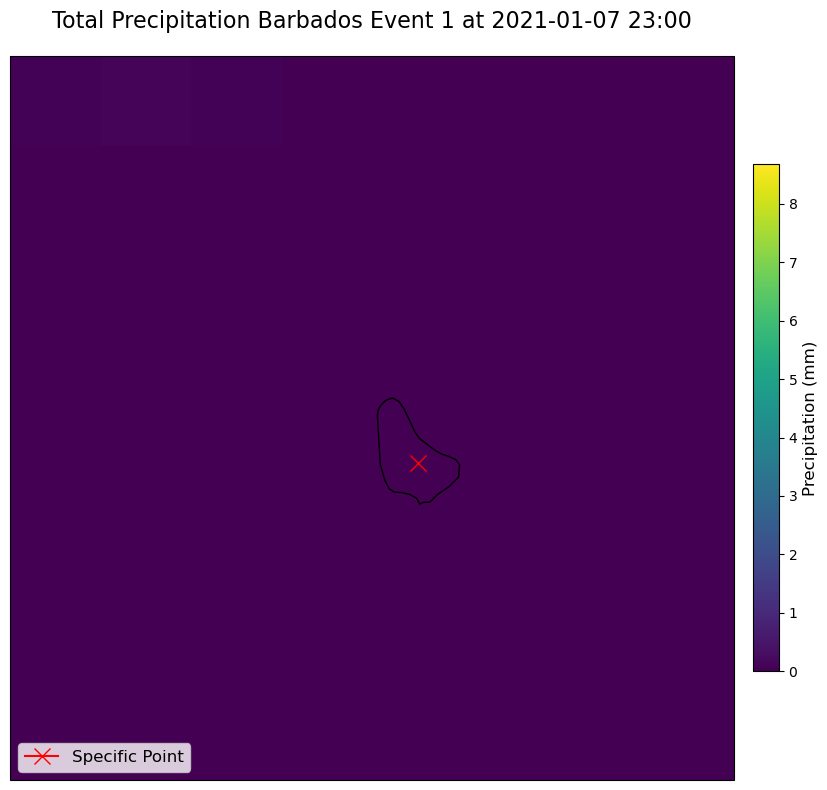

In [130]:
plot_era5_precipitation(
    dataset_path="Training_Babados/cropped_tipping/era5_cropped_tipping.nc",
    variable='tp',
    point_coords=(-59.54316, 13.16443),
    time_range=("2021-01-07 00:00", "2021-01-07 23:00"),
    title_base='Total Precipitation Barbados Event 1',
    cmap='viridis'
)


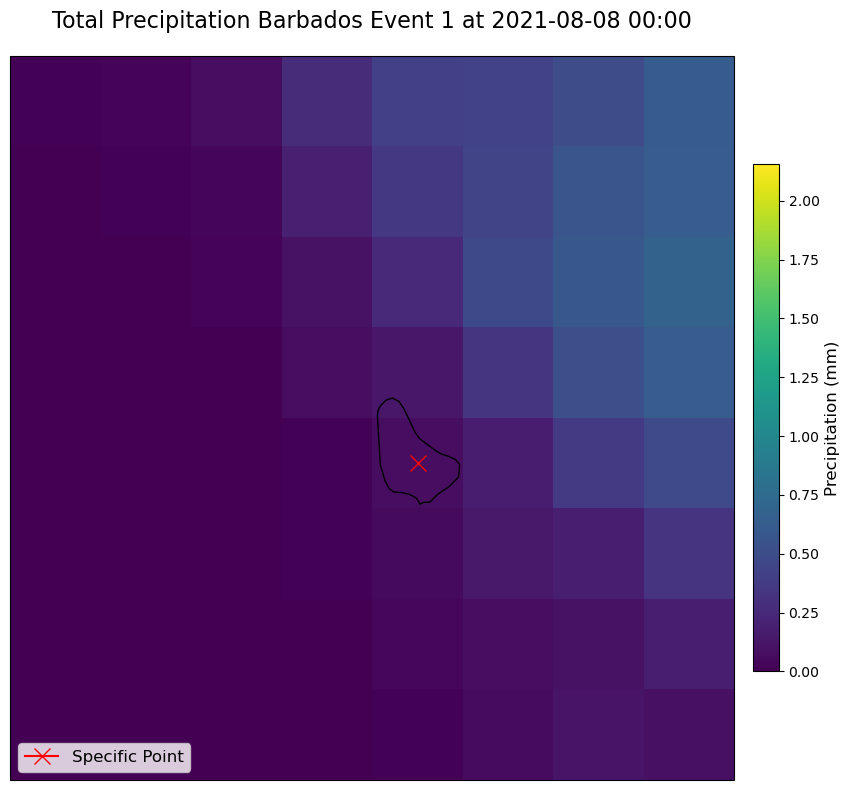

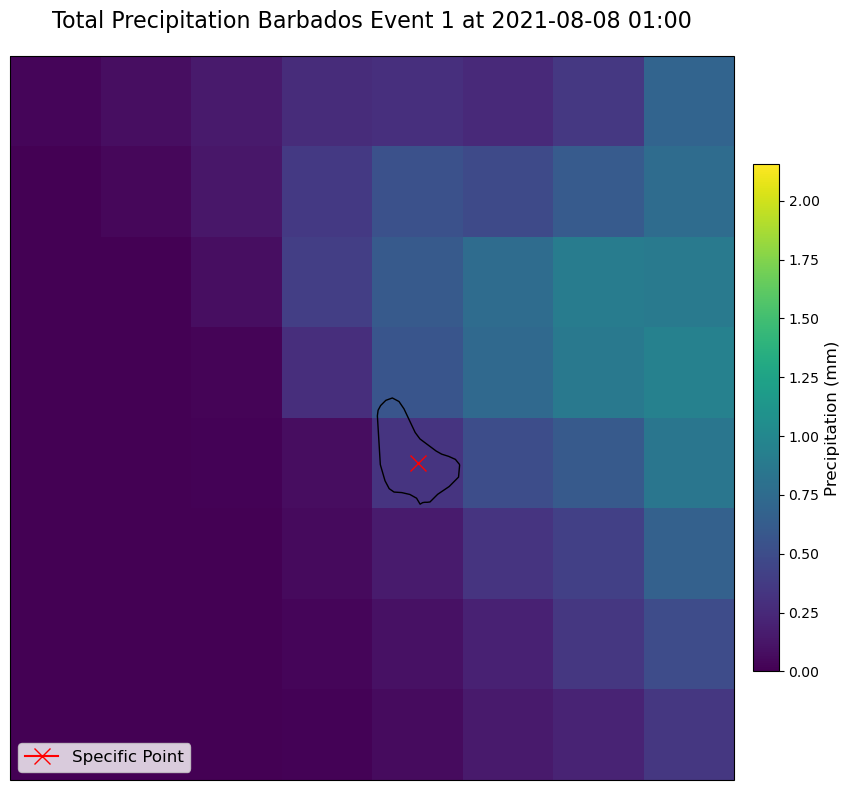

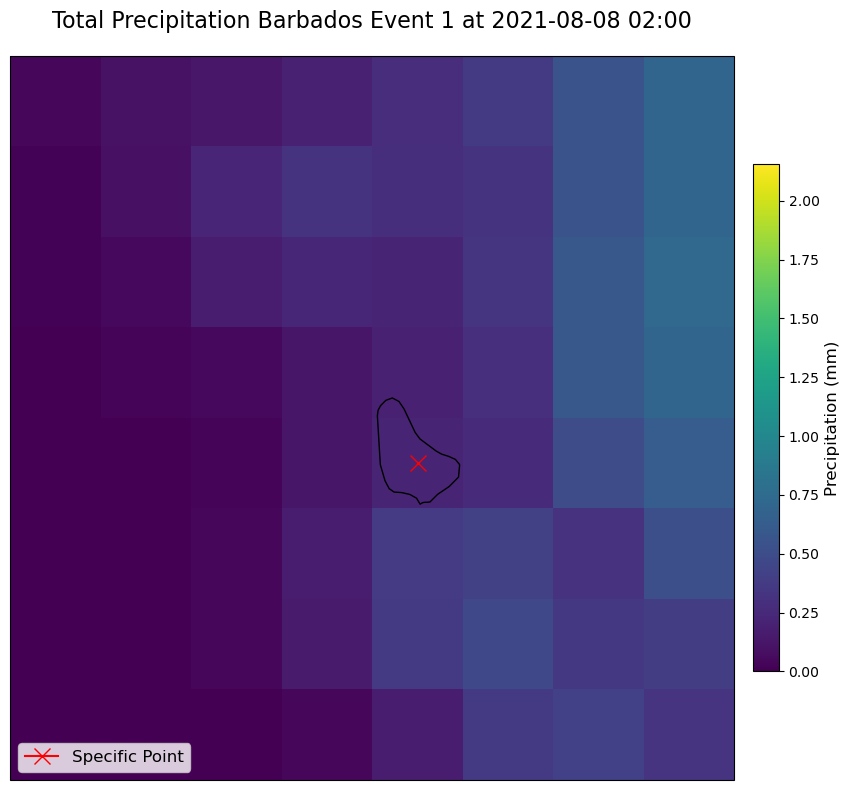

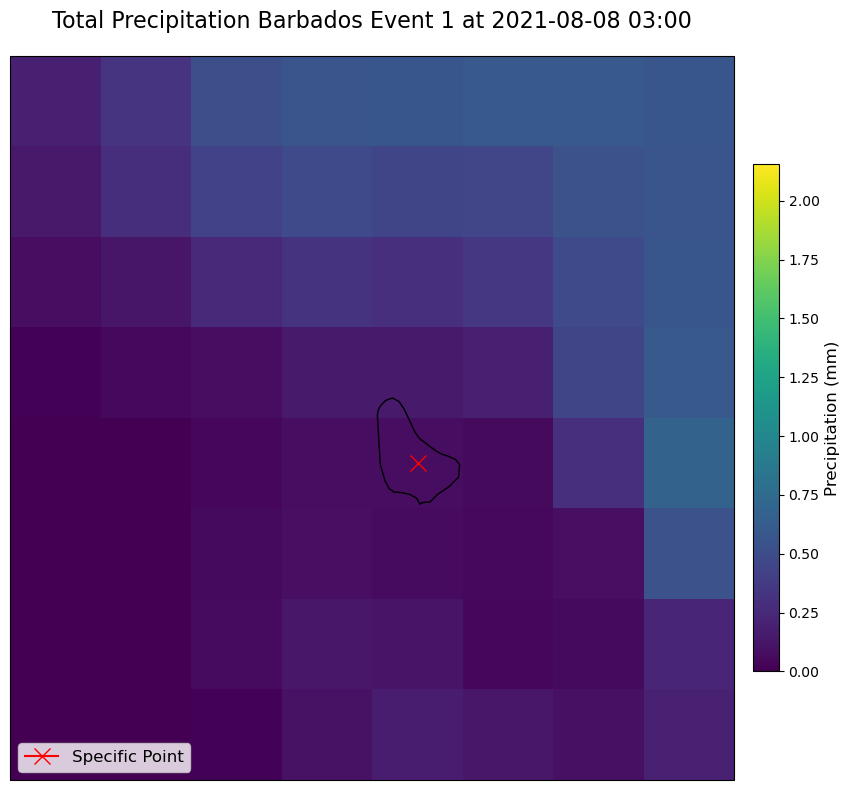

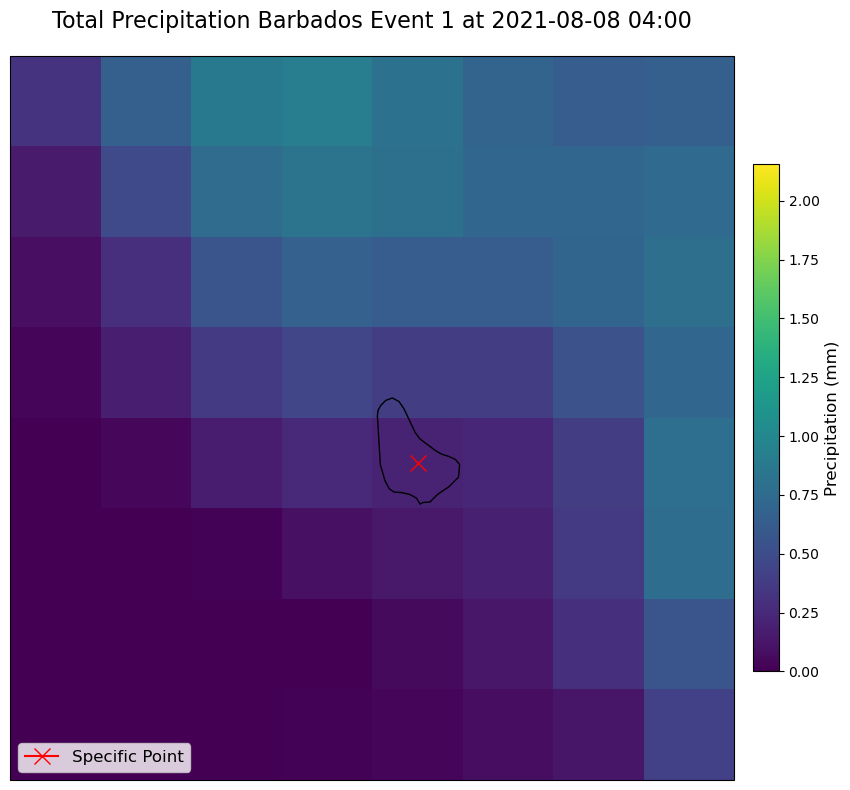

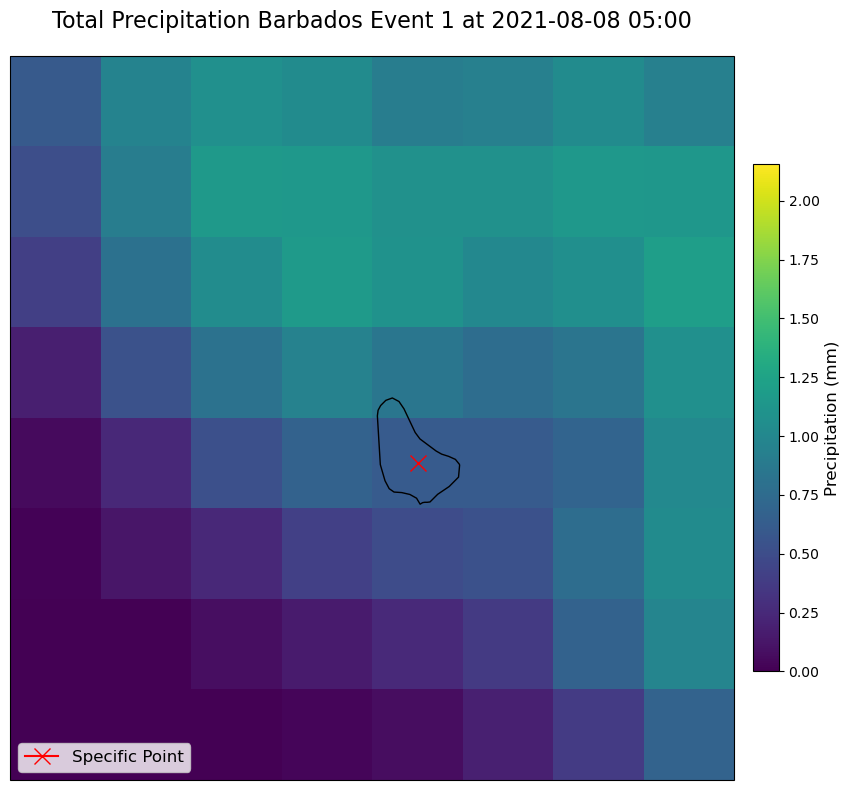

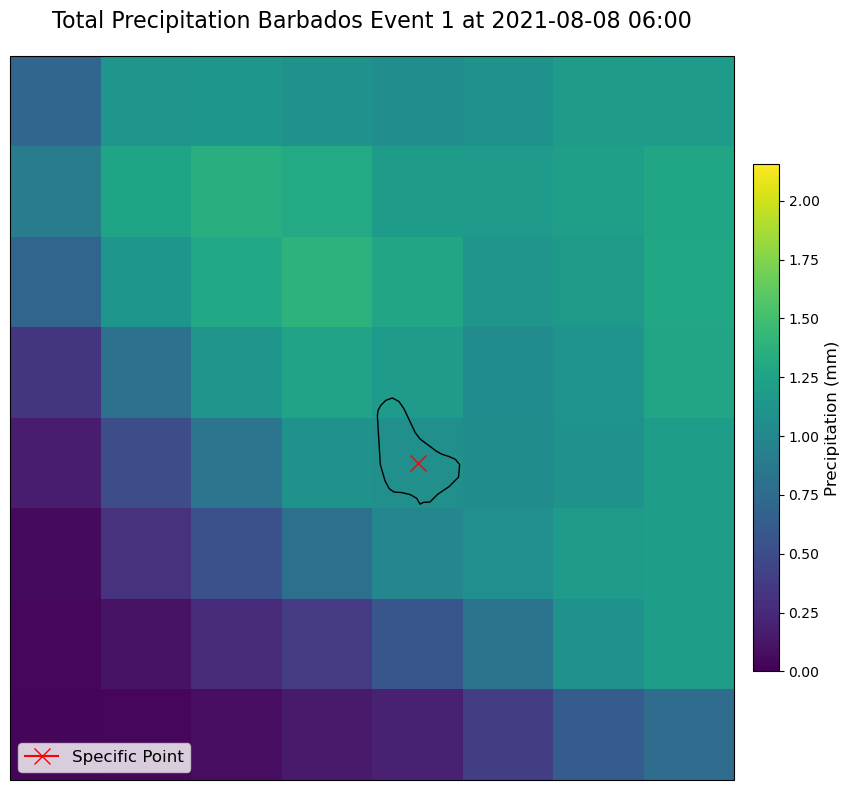

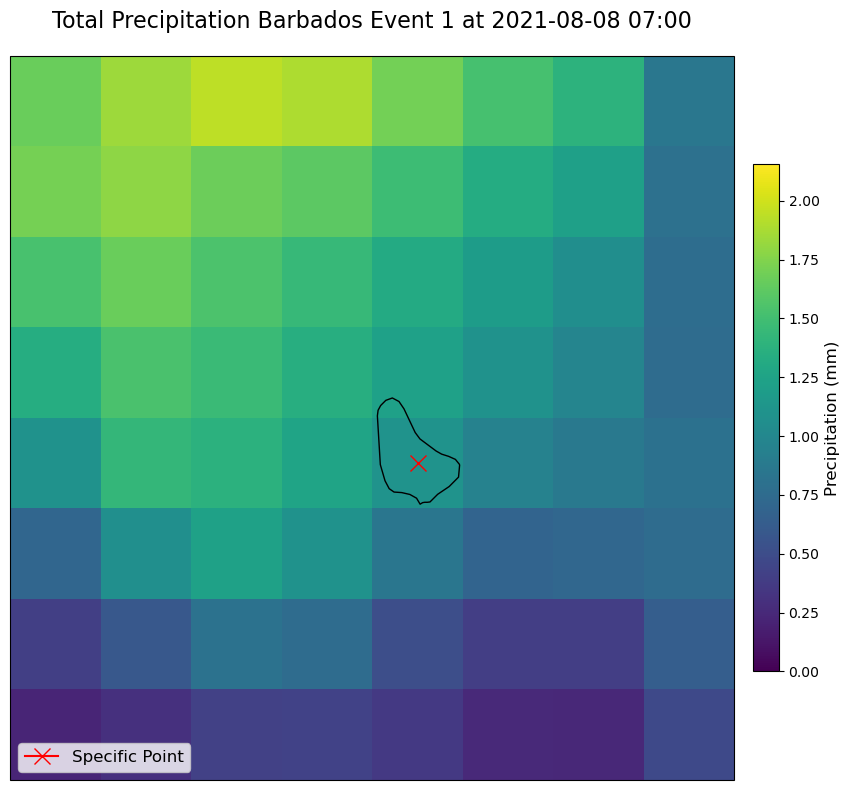

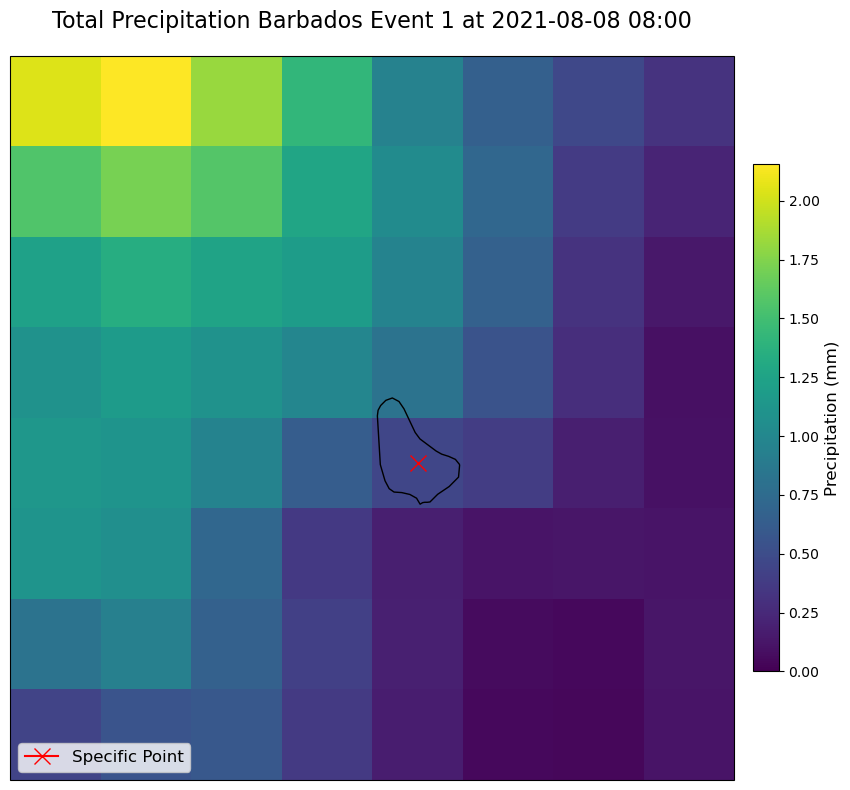

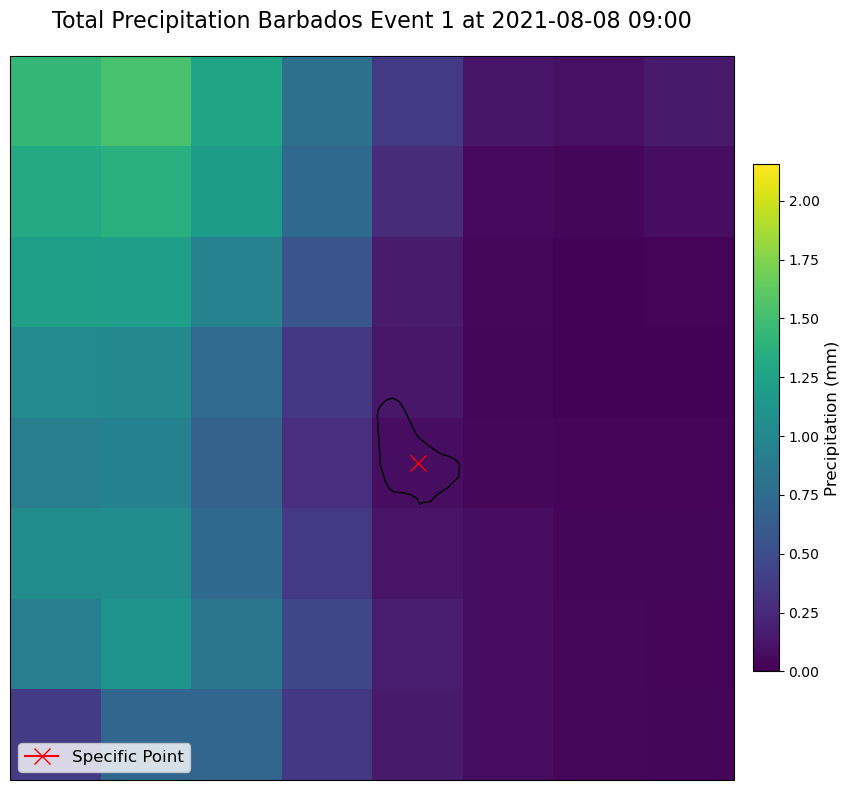

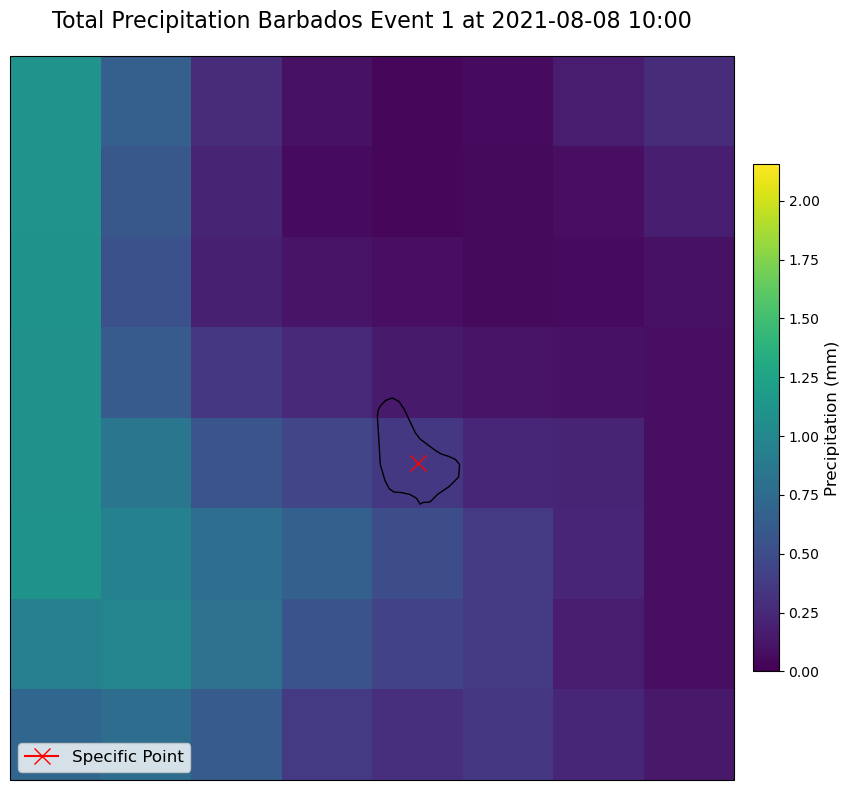

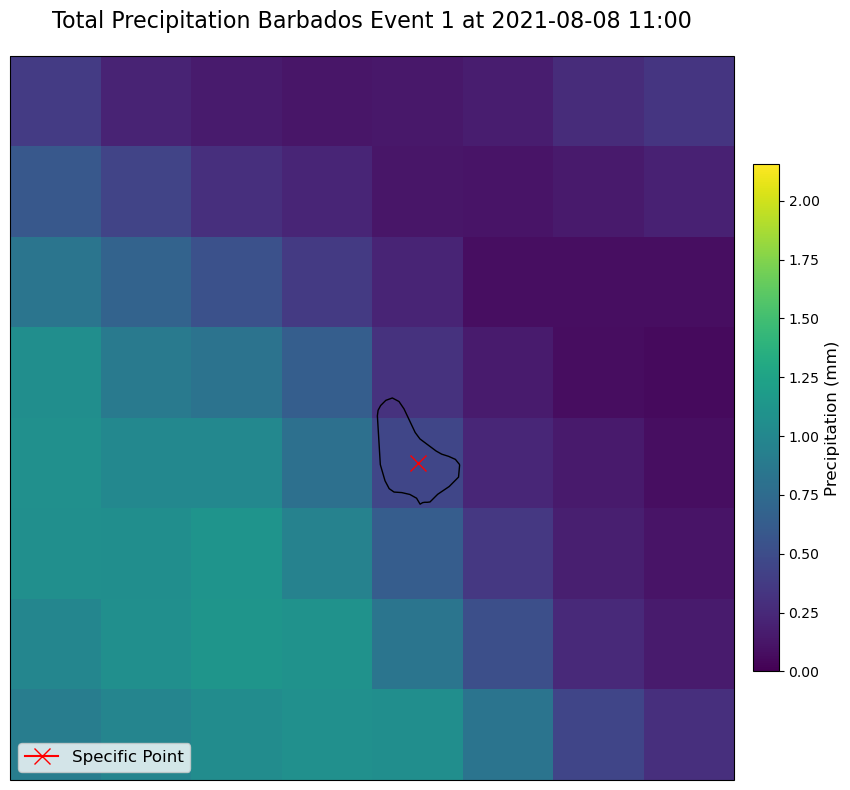

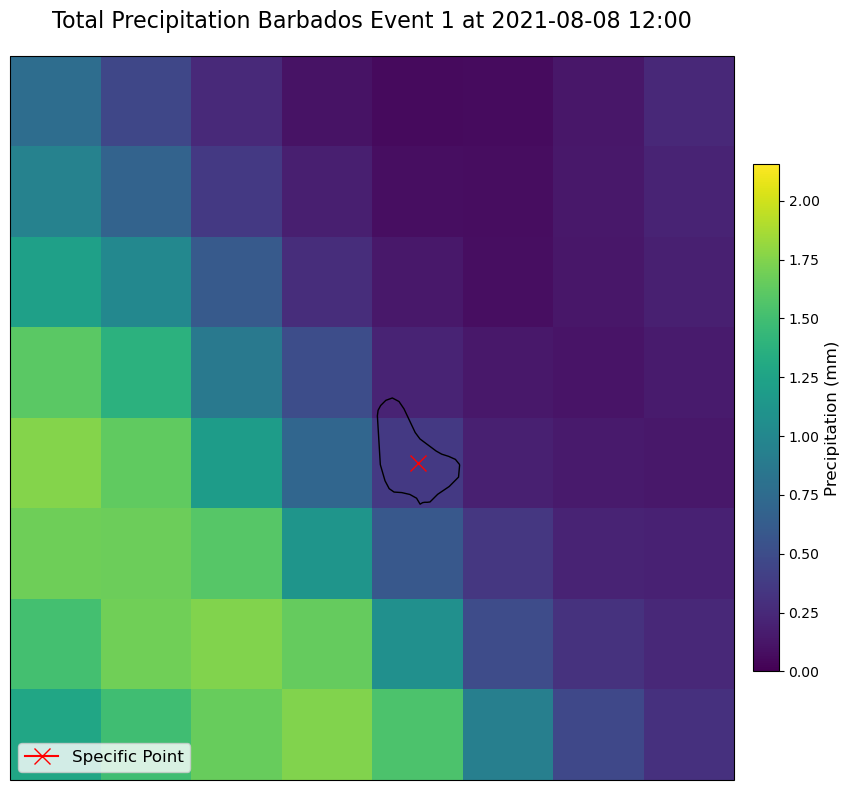

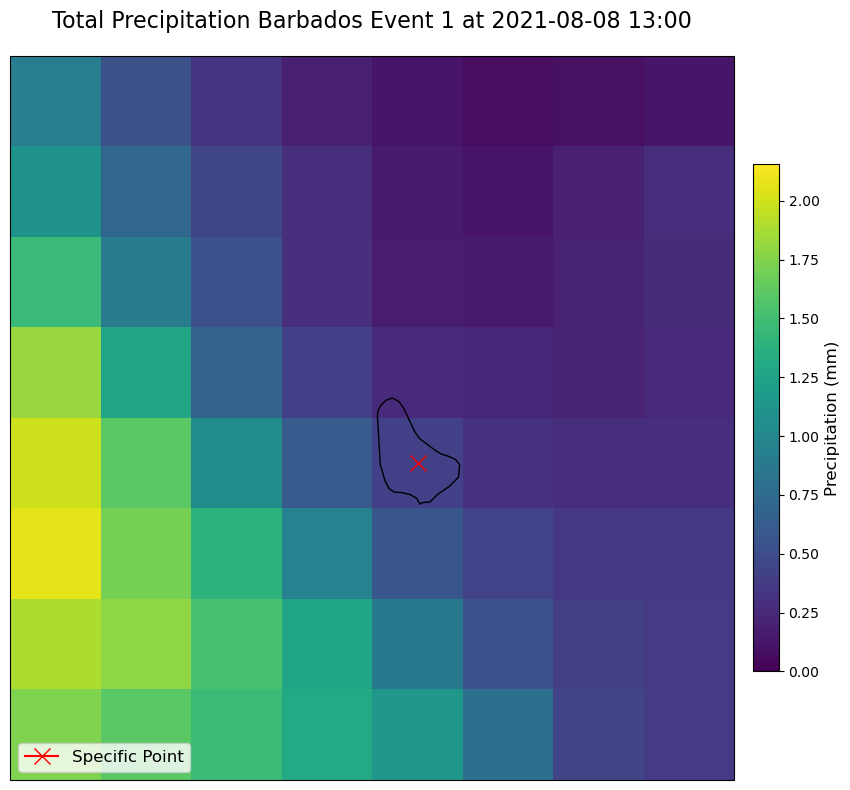

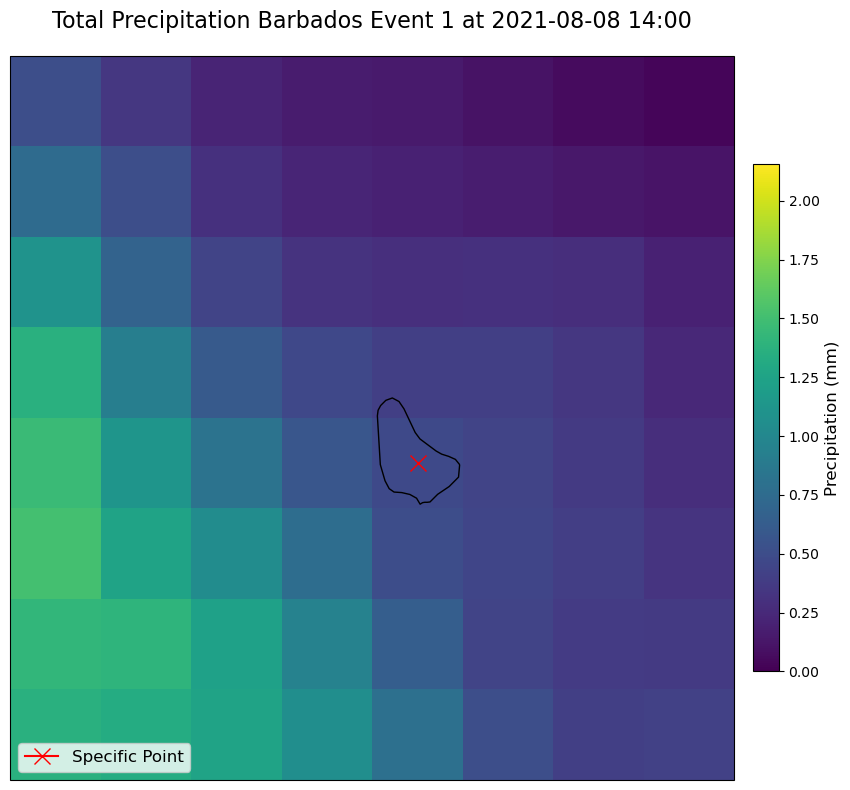

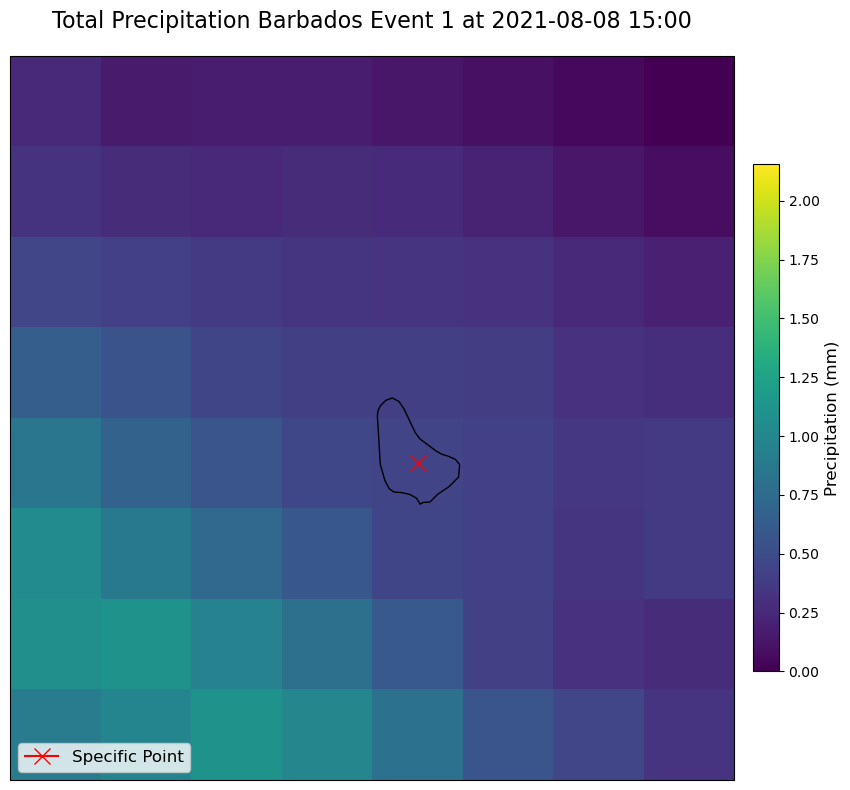

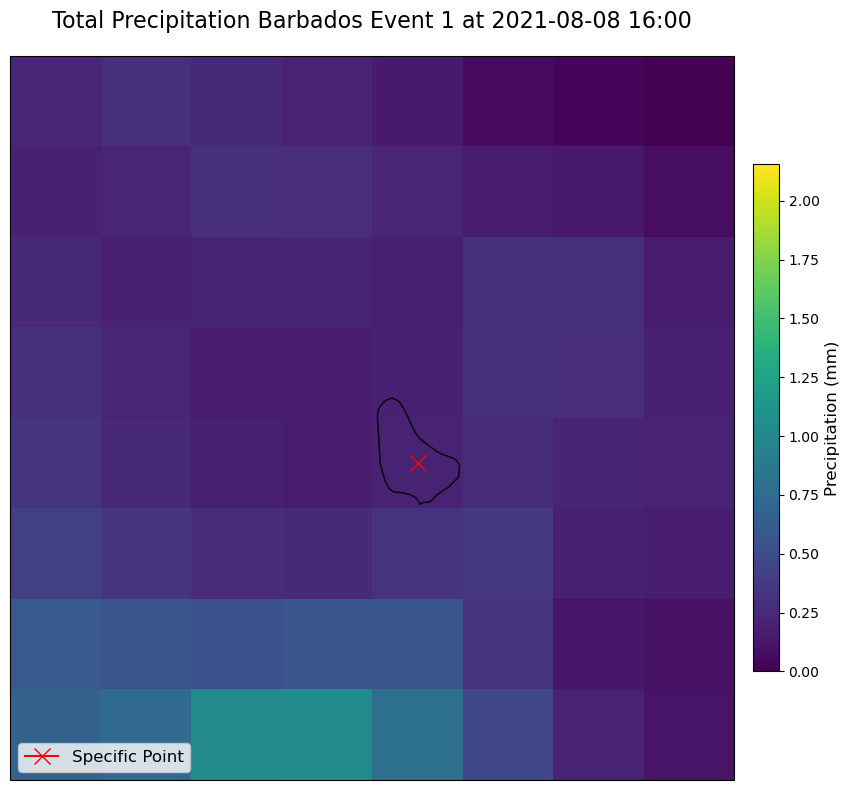

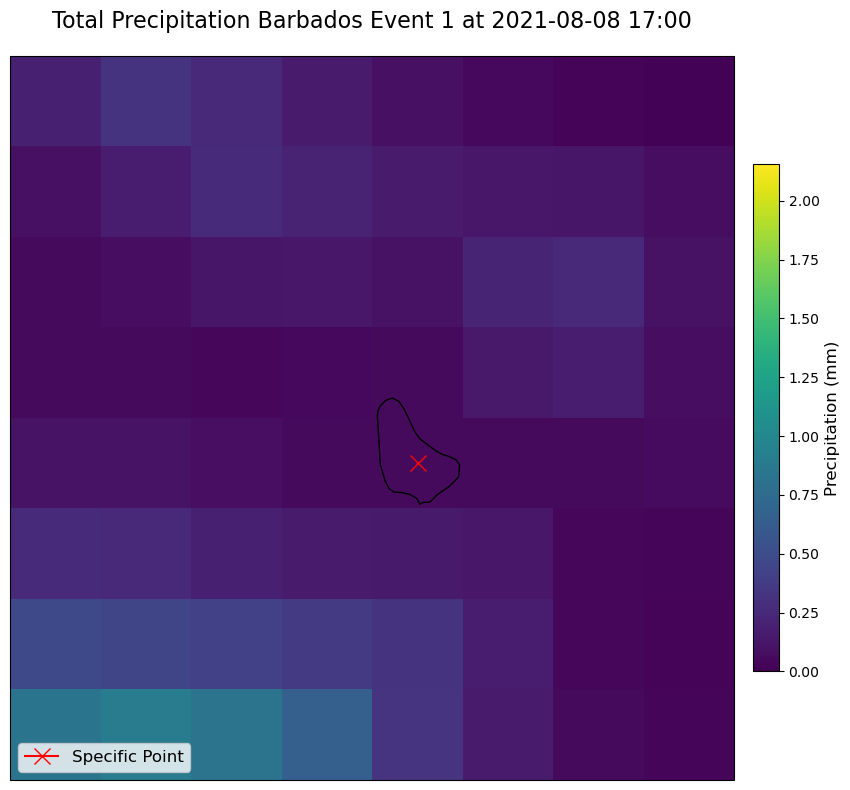

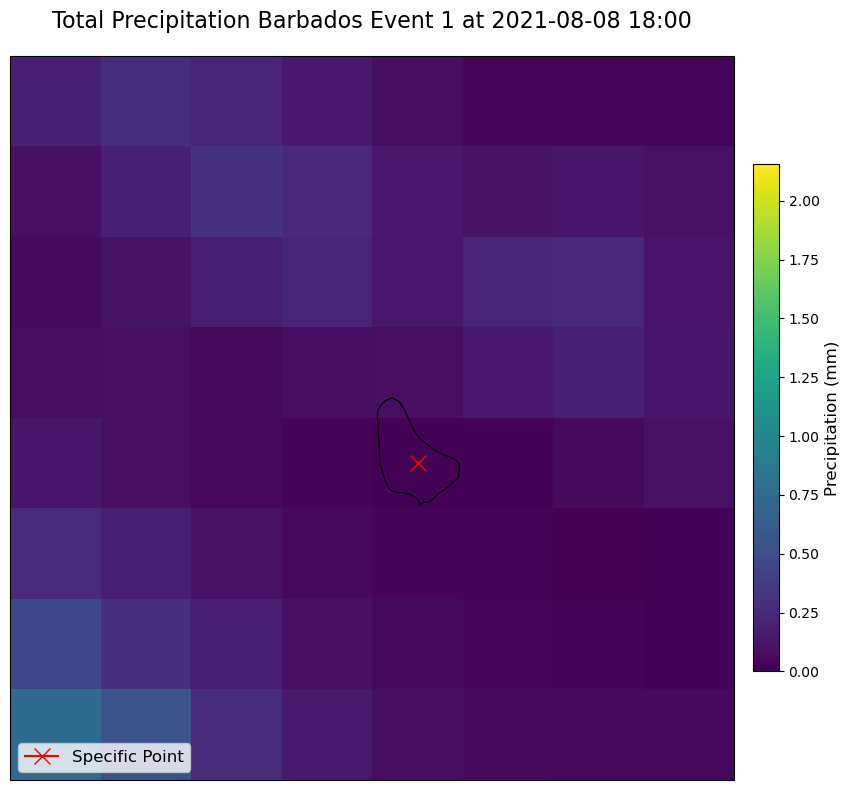

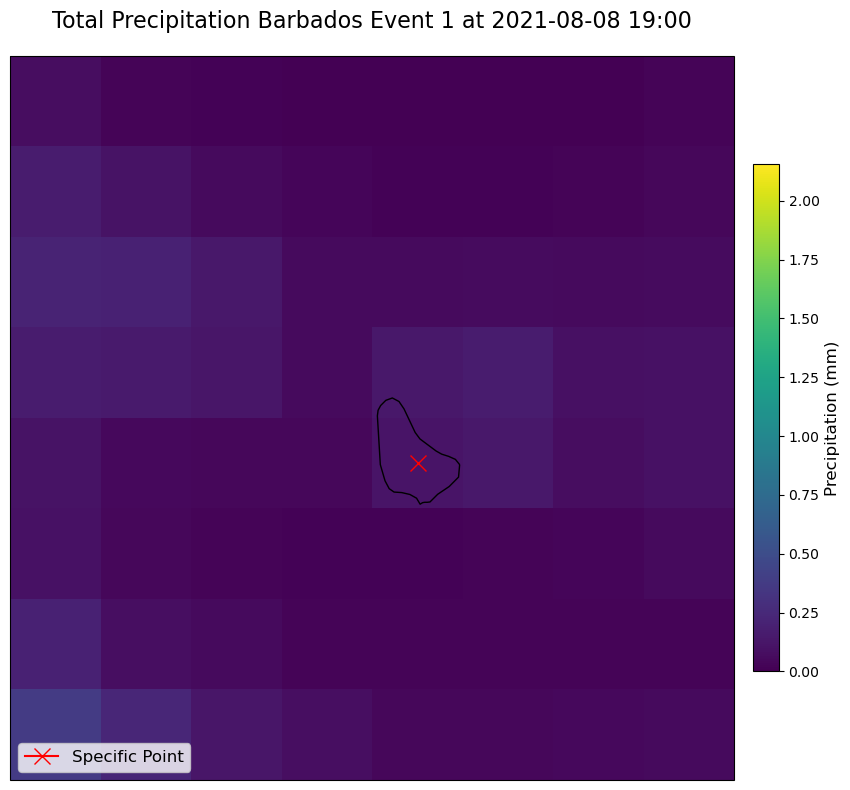

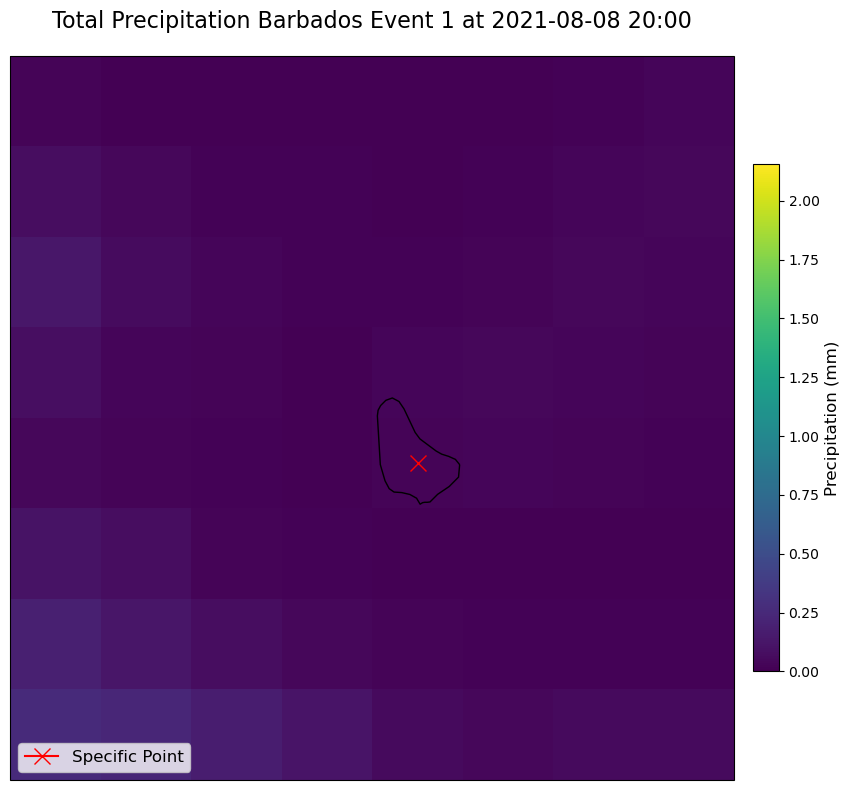

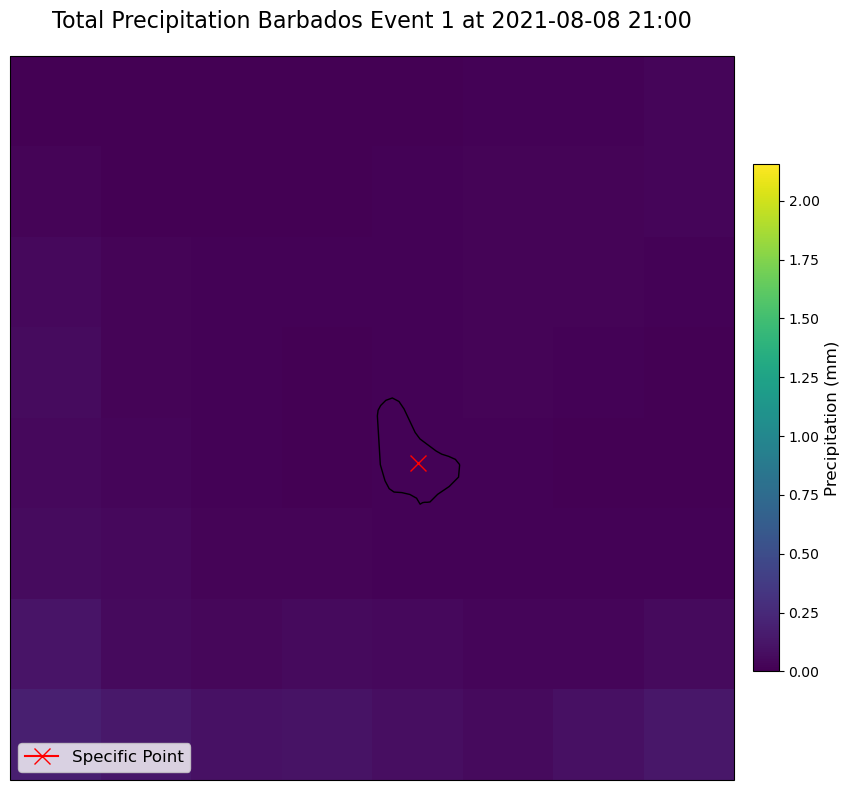

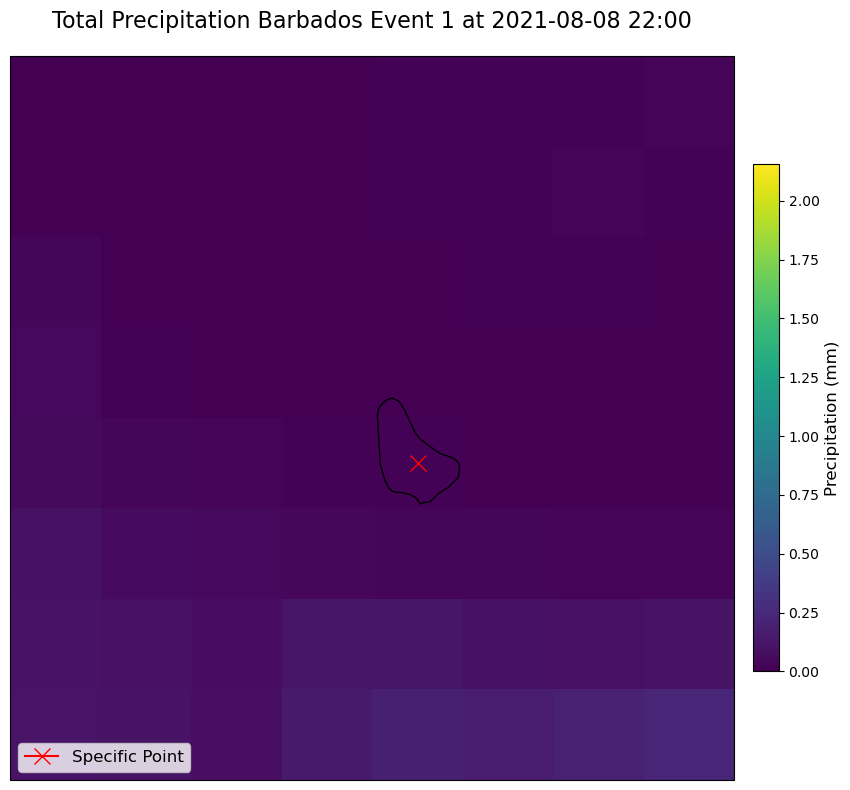

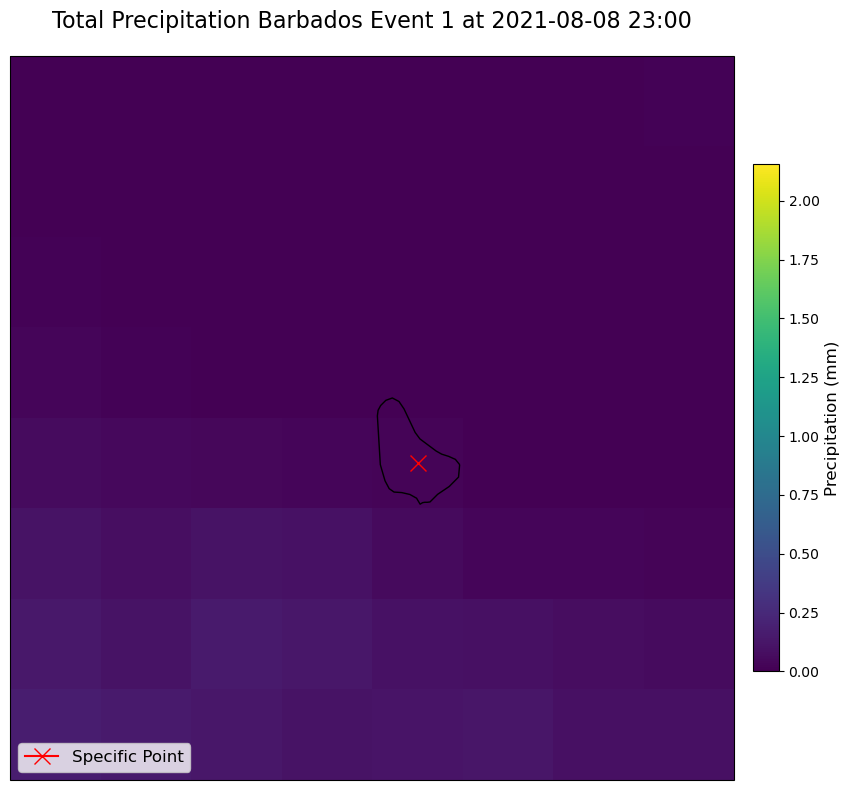

In [8]:
plot_era5_precipitation(
    dataset_path="Training_Babados/cropped_tipping/era5_cropped_tipping.nc",
    variable='tp',
    point_coords=(-59.54316, 13.16443),
    time_range=("2021-08-08 00:00", "2021-08-08 23:00"),
    title_base='Total Precipitation Barbados Event 1',
    cmap='viridis'
)


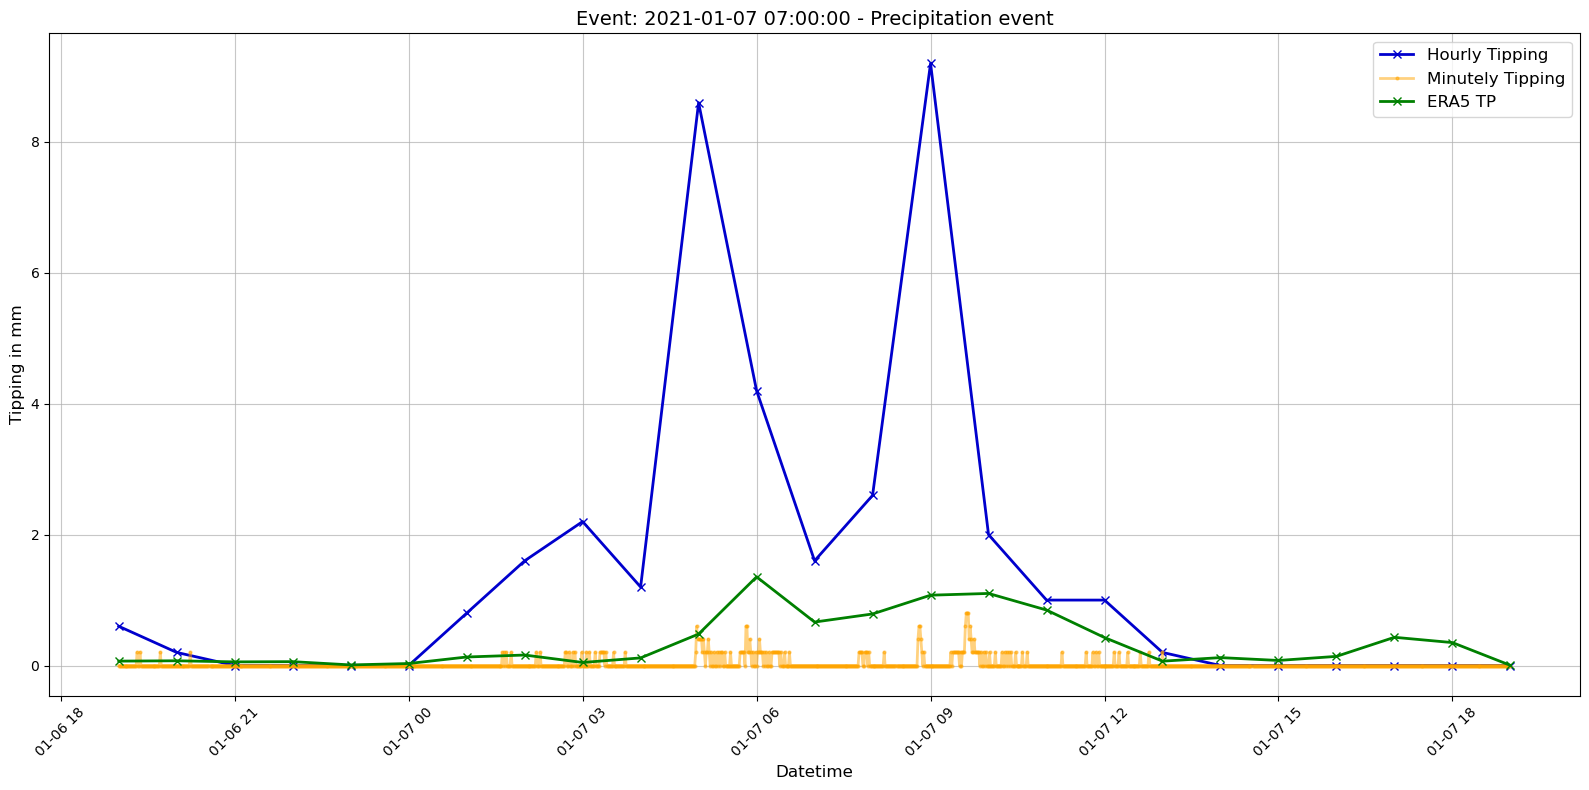

In [135]:
event_3 = pd.Timestamp("2021-01-07 07:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_df,
    era5_ds=era5_barbados,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)


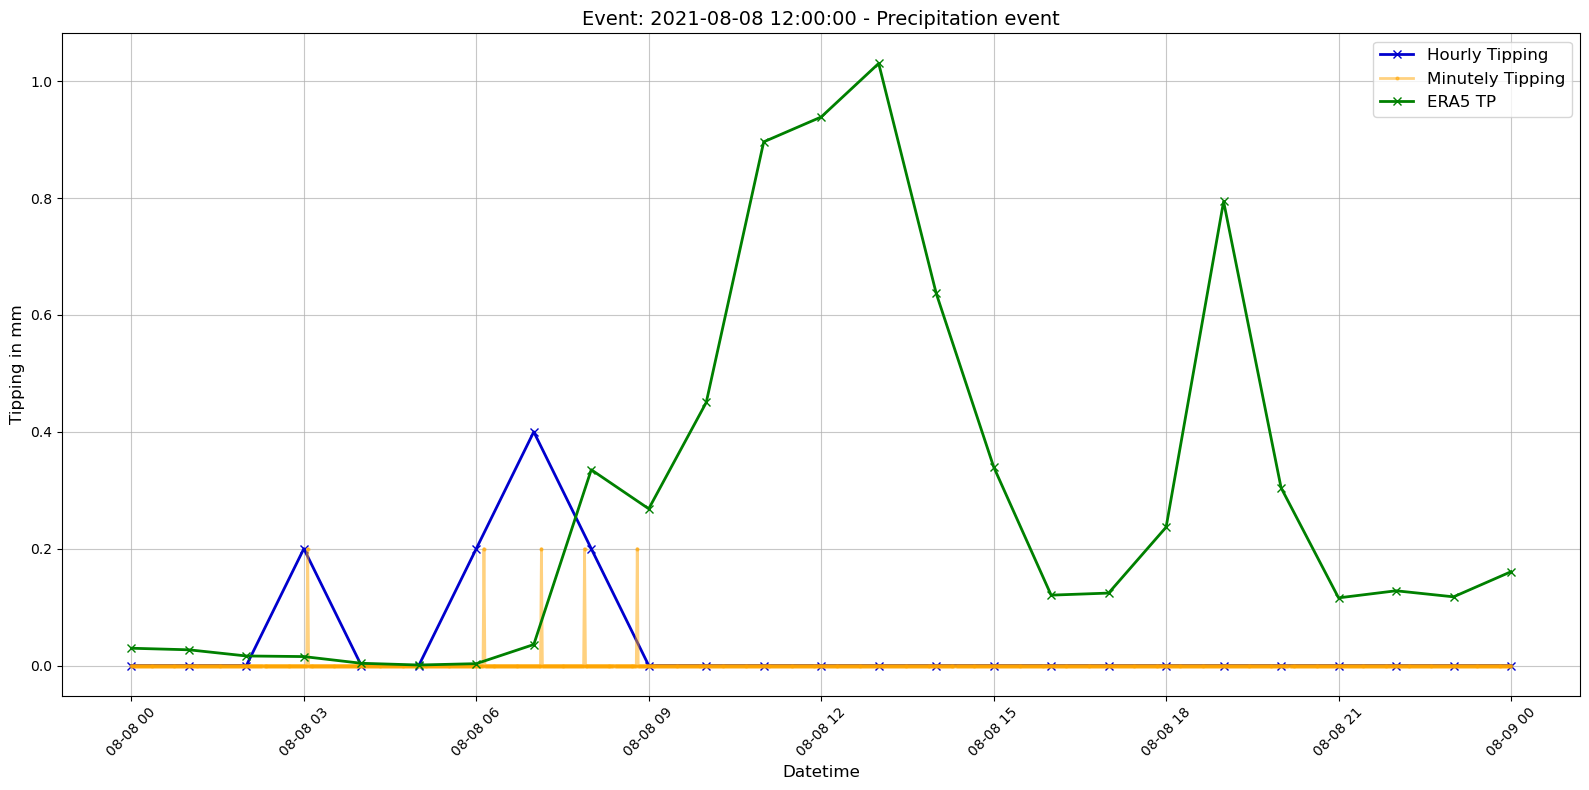

In [136]:
event_3 = pd.Timestamp("2021-08-08 12:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_df,
    era5_ds=era5_barbados,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)


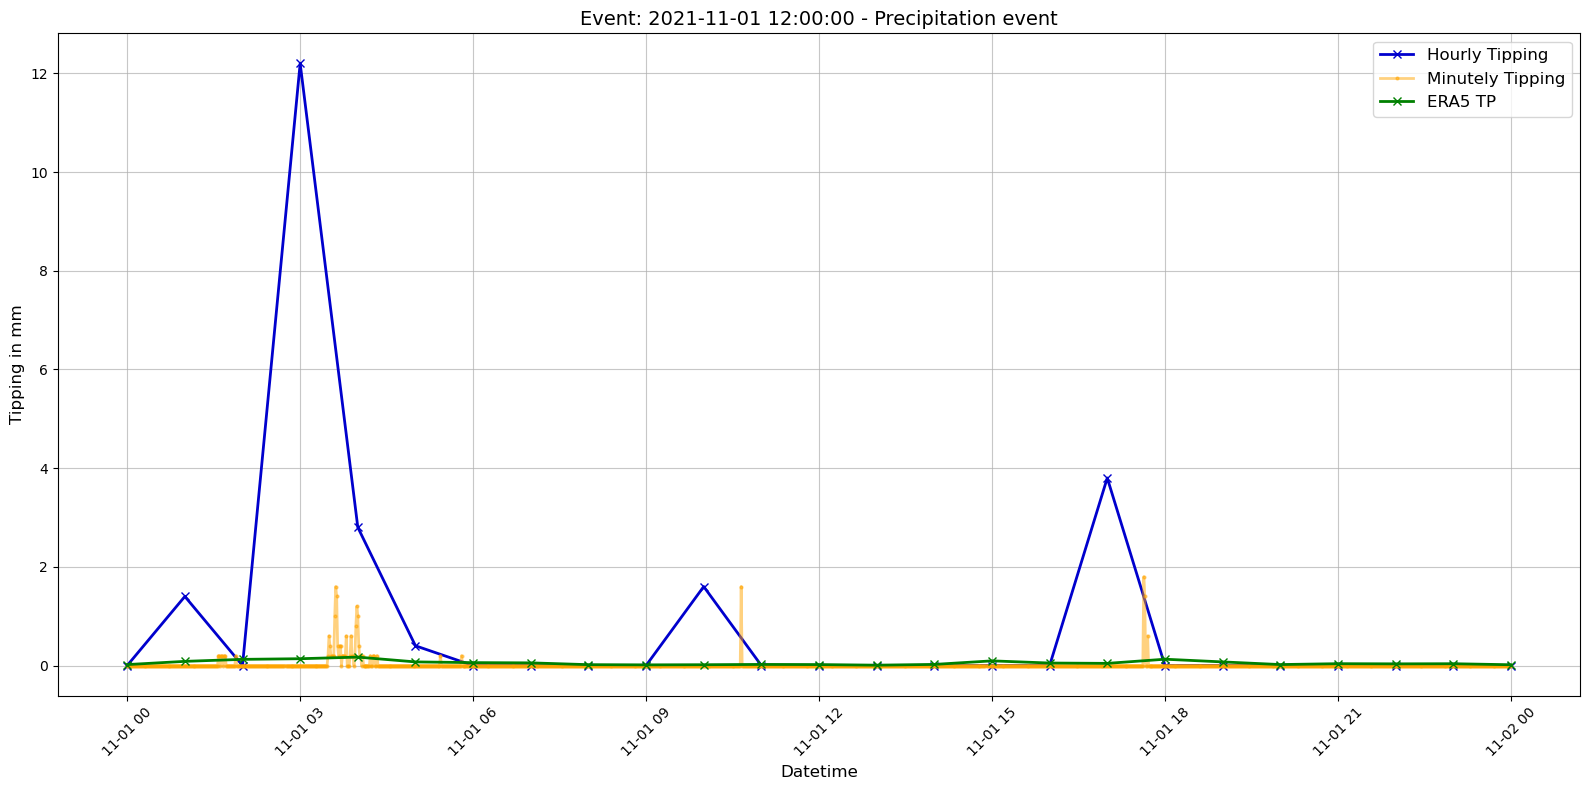

In [138]:
event_3 = pd.Timestamp("2021-11-01 12:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_df,
    era5_ds=era5_barbados,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443  ,
    lon=-59.54316 ,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)


In [11]:
event_3 = pd.Timestamp("2021-01-07 00:00:00")


In [18]:
era5_croppped = xr.open_dataset("Training_Babados/cropped_tipping/era5_cropped_tipping.nc")

In [24]:
# Ensure your dataset has a 'time' dimension with proper datetime indexing
one_day_data = era5_croppped.sel(time=slice("2021-01-07T00:00:00", "2021-01-07T23:00:00"))

# Inspect the selected data
print(one_day_data["tp"].mean(dim=["time"]))

<xarray.DataArray 'tp' (lat: 8, lon: 8)>
array([[0.05413607, 0.06390689, 0.07213885, 0.07940006, 0.07996785,
        0.08509789, 0.09138168, 0.08218084],
       [0.16766025, 0.17399961, 0.18132913, 0.19324774, 0.2051041 ,
        0.20500521, 0.21308537, 0.2118262 ],
       [0.31364956, 0.31790635, 0.32184273, 0.33178675, 0.34196177,
        0.3242145 , 0.33615157, 0.3615121 ],
       [0.50699097, 0.53654236, 0.551456  , 0.5264903 , 0.4982874 ,
        0.4848764 , 0.47811374, 0.48493227],
       [0.792293  , 0.9499102 , 0.9567757 , 0.75992537, 0.6966234 ,
        0.6492691 , 0.6401198 , 0.5639723 ],
       [1.1138198 , 1.2648509 , 1.2153202 , 0.9936345 , 0.8200504 ,
        0.75208145, 0.74478096, 0.6528546 ],
       [1.4263397 , 1.2867228 , 1.1924182 , 1.0133908 , 0.8724527 ,
        0.79942566, 0.7678638 , 0.7446587 ],
       [1.7270402 , 1.4065547 , 1.1270009 , 0.9549684 , 0.8785667 ,
        0.81028223, 0.75534886, 0.753026  ]], dtype=float32)
Coordinates:
  * lon      (lon) float64

In [26]:
barbados_hourly_df["tipping"].loc["2021-01-07 00:00:00":"2021-01-07 23:00:00"]

datetime
2021-01-07 00:00:00    0.0
2021-01-07 01:00:00    0.8
2021-01-07 02:00:00    1.6
2021-01-07 03:00:00    2.2
2021-01-07 04:00:00    1.2
2021-01-07 05:00:00    8.6
2021-01-07 06:00:00    4.2
2021-01-07 07:00:00    1.6
2021-01-07 08:00:00    2.6
2021-01-07 09:00:00    9.2
2021-01-07 10:00:00    2.0
2021-01-07 11:00:00    1.0
2021-01-07 12:00:00    1.0
2021-01-07 13:00:00    0.2
2021-01-07 14:00:00    0.0
2021-01-07 15:00:00    0.0
2021-01-07 16:00:00    0.0
2021-01-07 17:00:00    0.0
2021-01-07 18:00:00    0.0
2021-01-07 19:00:00    0.0
2021-01-07 20:00:00    0.0
2021-01-07 21:00:00    0.0
2021-01-07 22:00:00    0.0
2021-01-07 23:00:00    0.0
Name: tipping, dtype: float64

In [34]:
# Load the ERA5 dataset

# Define the target latitude and longitude
station_lat = 13.16443 #48.2303
station_lon =  -59.54316  #16.3609   # Example: Vienna longitude

# Select the nearest grid point
nearest_grid_point = era5_barbados.sel(lat=station_lat, lon=station_lon, method="nearest")


# Access a specific variable if needed
variable_nearest_grid = nearest_grid_point["tp"].sel(time=slice("2021-01-07T00:00:00", "2021-01-07T23:00:00"))
# Extract values as a list from the variable at the nearest grid point
values_as_list = variable_nearest_grid.values.tolist()

# Print values as a one-column list
for value in values_as_list:
    print(value)

0.030517578125
0.13017654418945312
0.16033649444580078
0.04649162292480469
0.1163482666015625
0.4812479019165039
1.3546943664550781
0.6642937660217285
0.7879734039306641
1.0747313499450684
1.101374626159668
0.8478760719299316
0.42724609375
0.06651878356933594
0.12090802192687988
0.07736682891845703
0.1398026943206787
0.43144822120666504
0.3504455089569092
0.0026226043701171875
0.003919005393981934
0.009141862392425537
0.018164515495300293
0.009894371032714844


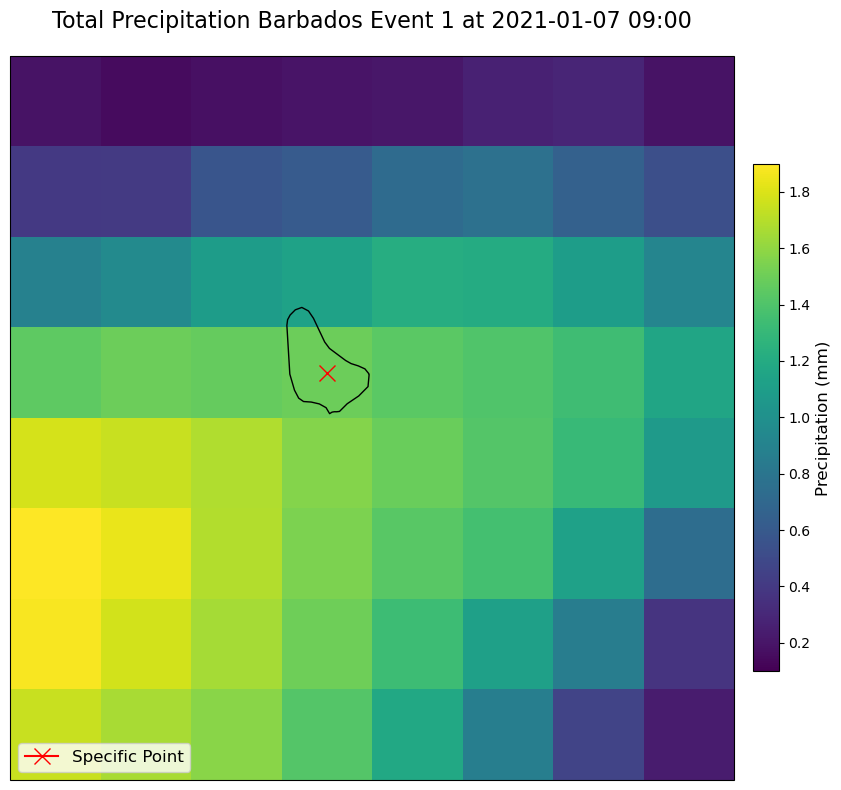

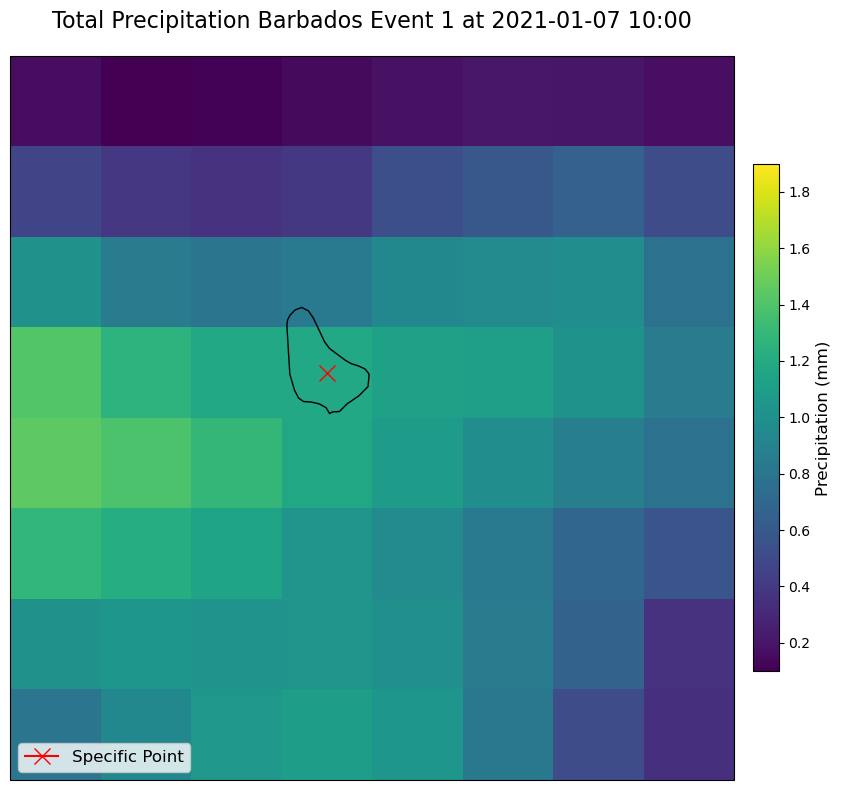

In [9]:
plot_era5_precipitation(
    dataset_path="Training_Babados/cropped_tipping/testing.nc",
    variable='tp',
    point_coords=(-59.54316, 13.16443),
    time_range=("2021-01-07 09:00", "2021-01-07 10:00"),
    title_base='Total Precipitation Barbados Event 1',
    cmap='viridis'
)